# Import packages

In [1]:
from array import array
import csv
import itertools
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

#import astroML.density_estimation as aml
#import astroML.plotting as amlplot
import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root

import ROOT

mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 16}) 
mpl.rcParams.update({'ytick.labelsize': 16}) 
mpl.rcParams.update({'text.usetex' : False})



Welcome to JupyROOT 6.09/01


# Get data from Ntuples
## Get dataframes from TTrees

In [2]:
def getData(inputFiles):
    maxEvents = 500000
    
    columns = []
    columns.append('ncluster')
    columns.append('ntrack')

    columns.append('run_number')
    columns.append('centrality_v0m')
    columns.append('eg_cross_section')
    columns.append('eg_ntrial')
    columns.append('time_stamp')
    columns.append('primary_vertex_ncontributor')
    columns.append('primary_vertex_spd_ncontributor')
    columns.append('npileup_vertex_spd')
    columns.append('bunch_crossing_number')
    columns.append('is_pileup_from_spd_3_08')
    columns.append('is_pileup_from_spd_5_08')
    columns.append('ue_estimate_its_const')
    columns.append('ue_estimate_tpc_const')

    columns.append('cluster_pt')
    columns.append('cluster_eta')
    columns.append('cluster_phi')
    columns.append('cluster_e_cross')
    columns.append('cluster_e')
    columns.append('cluster_e_max')

    columns.append('cluster_tof')
    columns.append('cluster_ncell')
 
    columns.append('cluster_iso_its_04')
    columns.append('cluster_iso_its_04_ue')
    #columns.append('cluster_iso_tpc_04')
    #columns.append('cluster_iso_tpc_04_ue')

    columns.append('cluster_iso_its_03')
    columns.append('cluster_iso_its_03_ue')
    
    columns.append('cluster_iso_04_truth')

    columns.append('cluster_isoetaband_its')
    columns.append('cluster_iso_its_new')


    columns.append('cluster_frixione_its_04_02')
    columns.append('cluster_nlocal_maxima')

    columns.append('cluster_NN1')
    columns.append('cluster_Lambda')
    columns.append('cluster_Lambda_angle')

    columns.append('cluster_SuperModule')
    columns.append('cluster_isHardPhoton')
    columns.append('cluster_distance_to_bad_channel')
    
    
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=columns,flatten=columns)
        dataframes.append(df)
        end = time.time()
        print 'Processed', inputFilename, 'in',  end-start, 'seconds'
    return pd.concat([x for x in dataframes])
    
    
    
    #start = time.time()
    #dataframe = rpd.read_root(inputFiles, columns=columns, flatten=True, stop=maxEvents)
    #end = time.time()
    #print 'Processed', ','.join(inputFiles), 'in', end-start, 'seconds'
    #    
    #return dataframe

## Define cuts and generate cut flow plots

In [95]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe

def applyCuts(fullDataframe,name='default',isMC=False): 
    fig = plt.figure(figsize=(9,6))
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['xtick.labelsize']=10 
    mpl.rcParams['axes.labelsize'] = 10

    fullDataframe.eval('cluster_ecross_over_e = cluster_e_cross/cluster_e', inplace=True)
         
    if('17g6a1_pthat1' in name):
        fullDataframe.eval('weights = 1.60e-11', inplace=True)
    elif('17g6a1_pthat2' in name):
        fullDataframe.eval('weights = 2.72e-12', inplace=True)
    elif('17g6a1_pthat3' in name):
        fullDataframe.eval('weights = 3.96e-13', inplace=True)
    elif('17g6a1_pthat4' in name):
        fullDataframe.eval('weights = 6.14e-14', inplace=True)
    elif('17g6a1_pthat5' in name):
        fullDataframe.eval('weights = 1.27e-14', inplace=True)
    
    elif('17g6a3_pthat1' in name):
        fullDataframe.eval('weights = 4.47e-11', inplace=True)
    elif('17g6a3_pthat2' in name):
        fullDataframe.eval('weights = 9.83e-11', inplace=True)
    elif('17g6a3_pthat3' in name):
        fullDataframe.eval('weights = 1.04e-10', inplace=True)
    elif('17g6a3_pthat4' in name):
        fullDataframe.eval('weights = 1.01e-10', inplace=True)
    elif('17g6a3_pthat5' in name):
        fullDataframe.eval('weights = 6.93e-11', inplace=True)    
    
    if(isMC and ('17g6' not in name)):       
        avg_eg_ntrial = str(np.mean(fullDataframe['eg_ntrial']))
        fullDataframe.eval('weights=eg_cross_section/'+avg_eg_ntrial, inplace=True)
    
    if(not isMC):
        fullDataframe.eval('weights = 1', inplace=True)
    fullDataframe.eval('cluster_emax_over_e = cluster_e_max/cluster_e', inplace=True)
  
    fullDataframe.eval('cluster_iso_truth = cluster_iso_04_truth', inplace=True)

    fullDataframe.eval('cluster_iso_its_04_raw = cluster_iso_its_04+cluster_iso_its_04_ue', inplace=True)
    fullDataframe.eval('cluster_iso_its_04_sub = cluster_iso_its_04+cluster_iso_its_04_ue - ue_estimate_its_const*0.4*0.4*3.1416', inplace =True)
    fullDataframe.eval('cluster_Lambda_Angle = 1.62*cluster_Lambda_angle', inplace=True)
    
    fullDataframe.eval('cluster_iso_its_03_raw = cluster_iso_its_03+cluster_iso_its_03_ue', inplace=True)
    fullDataframe.eval('cluster_iso_its_04_etaband = cluster_iso_its_04_raw- cluster_isoetaband_its*0.4*0.4*3.14/0.889', inplace=True)

    dataframe = fullDataframe
    
    #if('17g6a1' in name):  
    #    dataframe = applyCut(dataframe, 'cluster_iso_truth<5.0', 'cluster_iso_truth<5.0 :')
    
    dataframe["time_stamp"]= pd.to_datetime(dataframe['time_stamp'],unit='s',errors='coerce')

    if('13' in name):
        plt.title('p+Pb data',fontsize=16)
    elif('17' in name):
        plt.title('pp data',fontsize=16)
    plt.subplot(2,3,1)
    plt.hist(dataframe['cluster_pt'],bins=48, range=(12.0,60.0),color='black',histtype='step', 
             normed=True,weights=dataframe['weights'])
    dataframe = applyCut(dataframe, 'cluster_pt>12.0', 'pt >12.0  GeV/c :')
    dataframe = applyCut(dataframe, 'cluster_pt<100.0', 'pt <100.0  GeV/c :')
    plt.axvline(x=12.0,color='r',alpha=0.7)
    plt.axvline(x=30.0,color='r', alpha=0.7)
    plt.xlabel(r'cluster $p_{T}$ [GeV/c]')
    plt.yscale('log', nonposy='clip')
    
    dataframe = applyCut(dataframe, 'abs(cluster_eta)<0.67', '|eta| < 0.67 :')

    
    plt.subplot(2,3,2)
    plt.hist(dataframe['cluster_ncell'],range=(0,30), bins=30,color='black',histtype='step', normed=True,weights=dataframe['weights'])
    dataframe = applyCut(dataframe, 'cluster_ncell>2', 'ncell > 2:')
    plt.xlabel('Number of cells in cluster')
    plt.axvline(x=4.0,color='r',alpha=0.7)
    
    
    plt.subplot(2,3,3)
    plt.hist(dataframe['cluster_ecross_over_e'],bins=100,color='black',histtype='step', normed=True,weights=dataframe['weights'])
    dataframe = applyCut(dataframe, 'cluster_ecross_over_e>0.05', 'ecross/e > 0.05 :')
    plt.axvline(x=0.05,color='r',alpha=0.7)
    plt.xlabel(r'$E_{cross}/E_{cluster}$')
    plt.legend()
    

 
    #plt.subplot(2,3,3)
    #plt.hist(dataframe['cluster_distance_to_bad_channel'], bins=10,  range=(0,10), color='black',histtype='step', normed=True,weights=dataframe['weights'])
    #plt.xlabel('Distance to bad channel')
    #plt.axvline(x=2.0,color='r',alpha=0.7)
    #dataframe = applyCut(dataframe, 'cluster_distance_to_bad_channel>=3.0', 'Distance to bad channel >= 2.0 :')

    plt.subplot(2,3,4)
    plt.hist(dataframe['cluster_tof'], bins=100, range=(-100,100), color='black',histtype='step', normed=True,weights=dataframe['weights'])
    plt.xlabel('cluster time [ns]')


    if (not isMC) : 
        if( not('17q' in name)):
            dataframe = applyCut(dataframe, 'abs(cluster_tof)<20.0', '|cluster time| < 20 [ns]')
            plt.axvline(x=20.0,color='r',alpha=0.7)
            plt.axvline(x=-20.0,color='r',alpha=0.7)
    
    

    plt.subplot(2,3,5)
    plt.hist(dataframe['cluster_nlocal_maxima'], bins=7,  range=(-0.5,6.5), color='black',histtype='step', normed=True,weights=dataframe['weights'])
    plt.axvline(x=2.5,color='r',alpha=0.7)
    plt.xlabel('Number of local maxima')  
    dataframe = applyCut(dataframe, 'cluster_nlocal_maxima<3', 'Local Maxima < 3 :')
    
    #dataframe = applyCut(dataframe, 'cluster_NN1>0.02', 'cluster_NN1>0.02')
    #dataframe = applyCut(dataframe, 'cluster_Lambda_Angle>0.1', 'cluster_lambda >0.1')
    #dataframe = applyCut(dataframe, 'cluster_Lambda_Angle<2.0', 'cluster_lambda <2.0')

    
    plt.subplot(2,3,6)
    plt.hist(dataframe['cluster_iso_its_new'], bins=120,  range=(-10,110), color='black',histtype='step', normed=True,weights=dataframe['weights'])
    plt.axvline(x=1.5,color='r',alpha=0.7)
    plt.xlabel('ISO [GeV/c]')  
    plt.yscale('log', nonposy='clip')

    
    
    fig.tight_layout()
    plt.show()
    fig.savefig('ClusterCutFlow_dataset_%s.pdf'%name)
    
    
    print '# of isolated clusters:'
    
    isodata = applyCut(dataframe, 'cluster_iso_its_new<1.5', 'cluster_iso_its_new < 1.5 GeV/c:')
    applyCut(dataframe, 'cluster_iso_its_new<10 and cluster_iso_its_new>5.0', 'cluster_iso_its_new in 5--10 GeV/c:')
    
    

    
    
    plt.clf()
    plt.subplot(1,3,1)
    plt.hexbin(x=isodata['cluster_emax_over_e'], y=isodata['cluster_NN1'], cmap='viridis',bins="log")
    plt.xlabel(r'$E_{max}/E_{cluster}$')
    plt.ylabel('cluster_NN1')
    
    plt.subplot(1,3,2)
    plt.hexbin(x=isodata.query('cluster_Lambda<1.5')['cluster_emax_over_e'], y=isodata.query('cluster_Lambda<1.5')['cluster_Lambda'], cmap='viridis',bins="log") 
    plt.xlabel(r'$E_{max}/E_{cluster}$')
    plt.ylabel(r'$\sigma_{long}^{2}$')
    plt.ylim([0.0,1.5])
    plt.show()
    fig.tight_layout()
    fig.savefig('CorrelationDNN_EmaxE_%s.pdf'%name)

    fig = plt.figure(figsize=(20,20))        
    #PLOT ISOLATION DISTRIBUTIONS
    plt.subplot(4,4,5) 
    plt.hist(dataframe['cluster_frixione_its_04_02'], range=(-25,25), bins=100,label='Frixione_its',
             histtype='step',weights=dataframe['weights'])
    plt.hist(dataframe['cluster_iso_its_04'], range=(-25,25), bins=100,label='Cone_its',
             histtype='step',weights=dataframe['weights'])
    
    plt.hist(dataframe['cluster_iso_its_04_sub'], range=(-25,25), bins=100,label='Cone_its new',
             histtype='step',weights=dataframe['weights'])
    #plt.axvline(x=2.0, color='r')
    #plt.axvline(x=5.0, color='g')
    plt.yscale('log', nonposy='clip')
    plt.legend()
    plt.xlabel('cluster track-isolation [GeV/c]')

    plt.subplot(4,4,6) 
    plt.hist(dataframe['cluster_iso_its_04'], range=(-25,25), cumulative = True, bins=100,label='Cone_its',histtype='step', normed=True,weights=dataframe['weights'])
    plt.xlabel('cluster track-isolation [GeV/c]')
    plt.ylabel('cumulative distribution')
    plt.legend()
    
    plt.subplot(4,4,7) 
    plt.hist(dataframe['ue_estimate_its_const'], range=(0,200), bins=400,color='black',histtype='step', label ='rho its', normed=True,weights=dataframe['weights'])
    plt.xlabel('Underlying event subtraction [GeV/c]')
    plt.yscale('log', nonposy='clip')
    
    plt.subplot(4,4,8)
    plt.hist(dataframe['cluster_iso_its_04'], range=(-3,3), bins=20,label='Cone_its',
             histtype='step',weights=dataframe['weights'])
    plt.hist(dataframe['cluster_iso_its_04_sub'], range=(-3,3), bins=20,label='Cone_its_sub',
             histtype='step',weights=dataframe['weights'])
    plt.xlabel('cluster track-isolation [GeV/c]')
    plt.legend()
    
    plt.subplot(4,4,9)
    plt.hist(dataframe['cluster_NN1'], bins=50,range=(0,1.0), color='black',histtype='step', normed=True,weights=dataframe['weights'])
    plt.xlabel('cluster NN')

 
    plt.subplot(4,4,10)
    dataframe['cluster_SuperModule'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('cluster supermodule')
    
    plt.subplot(4,4,11)
    dataframe['run_number'].value_counts().sort_index().plot(kind='bar')
       
    plt.subplot(4,4,12)
    plt.hist(dataframe['ncluster'], bins=30, range=(0,30), color='black',histtype='step', 
             normed=True,weights=dataframe['weights'])
    plt.xlabel('# of clusters in event')
    
    plt.subplot(4,4,13)
    plt.hist(dataframe['cluster_emax_over_e'], bins=100,  range=(0,1.0), color='black',histtype='step',
             normed=True,weights=dataframe['weights'])
    plt.xlabel(r'$E_{max}/E_{cluster}$')

    plt.subplot(4,4,14)
    dataframe['npileup_vertex_spd'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('npileup_vertex_spd')
    
    plt.subplot(4,4,15)
    plt.hist(dataframe['cluster_Lambda'], bins=100,  range=(0,2.0), color='black',histtype='step', normed=True, 
             label='Lambda',weights=dataframe['weights'])

    plt.legend()
      
    plt.subplot(4,4,16)
    plt.hist(dataframe['centrality_v0m'], color='black',histtype='step', normed=True, label='all',weights=dataframe['weights'])
    plt.xlabel('Centrality')
    
   
    plt.show()
    fig.tight_layout()
    fig.savefig('Cutflow_dataset_%s.png'%name)

    #fig = plt.figure(figsize=(12,12))
    #for ism in range(20):
    #    plt.subplot(4,5,ism+1)
    #    plt.hist(isodata[isodata.cluster_SuperModule==ism]['cluster_NN1'], bins=20,range=(0,1.0), normed=True, color='black',
    #             label='SM=%i'%(ism), histtype='step',weights=isodata[isodata.cluster_SuperModule==ism]['weights'])
    #    plt.legend(loc='best')
    #    plt.ylim([0.0,6.0])

            
    #fig.savefig('Supermodules_DNN%s.png'%name)
    

            
    fig.savefig('Supermodules_EmaxOverE%s.png'%name)


    return dataframe

# Build templates from dataframes

In [4]:
def getIsoSplitHists(data, bins, isoCut, nonisoCuts, var, isovar, varRange):
    hfull, binEdges = np.histogram(data[var], bins, range=varRange, weights=data['weights'])
    hiso, _ = np.histogram(data.query('%s<%f '%(isovar,isoCut))[var], binEdges, 
                           range=varRange, weights = data.query('%s<%f '%(isovar,isoCut))['weights'])
    hnoniso, _ = np.histogram(data.query('%s>%f and %s<%f'%(isovar,nonisoCuts[0],isovar, nonisoCuts[1]))[var], binEdges, 
                              range=varRange, weights = data.query('%s>%f and %s<%f'%(isovar,nonisoCuts[0],isovar, nonisoCuts[1]))['weights'])

    return hfull, hiso, hnoniso, binEdges

#it was 10-15 GeV
def getTemplates(dataHists, mcHists, bins, isocut=1.5, nonisocuts=(4,10), var='cluster_NN1', isovar='cluster_iso_its_04_sub', varRange=(0.0, 1.0)):
    _, dataiso, datanoniso, binEdges = getIsoSplitHists(dataHists, bins, isocut, nonisocuts, var, isovar, varRange)
    #signalmc, _ = np.histogram(mcHists[var], binEdges, range=varRange)
    _, signalmc, _bkg, binEdges = getIsoSplitHists(mcHists, bins,isocut,nonisocuts,var,isovar,varRange)
     
    dataisoerr = np.sqrt(dataiso)
    datanonisoerr = np.sqrt(datanoniso)
    signalmcerr = np.sqrt(signalmc)
    
    return dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges

# Define template fit and purity

In [5]:
def haveSameLength(*args):
    n = len(args[0])
    return all(len(l) == n for l in args)

def normalize(x):
    return np.array(x, dtype='f')/np.sum(x)

def getBinRange(binEdges, valuemin, valuemax):
    binmin = min([i for i, edge in enumerate(binEdges) if edge >= valuemin])
    binmax = max([i for i, edge in enumerate(binEdges) if edge <= valuemax])
    return binmin, binmax
    
def getPurity(signal, bkg, binEdges, frac, purityMin, purityMax, returnRange=False):
    # signal and bkg should be normalized to 1
    pmin, pmax = getBinRange(binEdges, purityMin, purityMax)
    purity = np.sum(frac*signal[pmin:pmax])/(np.sum([(1-frac)*bkg[pmin:pmax], frac*signal[pmin:pmax]]))
    
    if returnRange:
        return purity, pmin, pmax
    else:
        return purity
    
def getEfficiency(signal, binEdges, purityMin, purityMax):
    pmin, pmax = getBinRange(binEdges, purityMin, purityMax)
    efficiency =  np.sum(signal[pmin:pmax])/np.sum(signal)
    
    return efficiency

class TemplateFit:
    def __init__(self, data, dataerr, signal, signalerr, bkg, bkgerr, binEdges, fitRange=None, verbosity=1, fixN=True,
                 fixNsig =False, Nsig0=100):       
        if not haveSameLength(data, dataerr, signal, signalerr, bkg, bkgerr, binEdges[1:]):
            raise ValueError('Inputs do not have the same length (binEdges should have 1 more than the rest)')
        
        self.data = np.array(data, dtype='f')
        self.dataerr = np.array(dataerr, dtype='f')
        self.inputSignal = np.array(signal, dtype='f')
        self.inputSignalerr = np.array(signalerr, dtype='f')
        self.inputBkg = np.array(bkg, dtype='f')
        self.inputBkgerr = np.array(bkgerr, dtype='f')
        self.binEdges = binEdges
        self.fixN = fixN
        self.fixNsig = fixNsig
        self.Nsig0   = Nsig0
        if fitRange:
            self.fitRange = getBinRange(binEdges, *fitRange)
        else:
            self.fitRange = (0, None)
        
        self.signal = self.inputSignal/np.sum(self.inputSignal)
        self.signalerr = self.inputSignalerr/np.sum(self.inputSignal)
        self.bkg = self.inputBkg/np.sum(self.inputBkg)
        self.bkgerr = self.inputBkgerr/np.sum(self.inputBkg)
        self.binCenters = np.array([(hedge+ledge)/2.0 for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
        self.binWidths = np.array([hedge-ledge for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
               
        self.signalColor = '#3B7EA1'
        self.bkgColor = '#FDB515'
        self.figureSize = (10, 8)
        
        self.verbosity = verbosity
               
        self.doFit()
        
    def doFit(self):
        def Chi2(N, Nsig):
            model = Nsig*self.signal + (N-Nsig)*self.bkg #model = N*(f*self.signal + (1-f)*self.bkg)
            totalerror = np.sqrt(np.square(self.dataerr) + np.square((N-Nsig)*self.bkgerr))
            return np.sum(np.power(np.divide(self.data-model, totalerror,
                                             out=np.zeros_like(totalerror), where=totalerror!=0), 2.0)[slice(*self.fitRange)])

        mt = iminuit.Minuit(Chi2, N=np.sum(self.data), fix_N=self.fixN,  Nsig=self.Nsig0, fix_Nsig = self.fixNsig, 
                            error_N=1, error_Nsig=1, print_level=self.verbosity, limit_Nsig=(0,1e4))#errordef=1,
        migradresult = mt.migrad()
        
        #hesseresult = mt.hesse()
        #if(mt.migrad_ok()):
        #    mt.hesse()
        
        if( not mt.migrad_ok()):
            mt = iminuit.Minuit(Chi2, N=np.sum(self.data), fix_N=self.fixN,  Nsig=self.Nsig0*1.2, fix_Nsig = self.fixNsig, 
                            error_N=5, error_Nsig=5, print_level=self.verbosity, limit_Nsig=(0,1e4))#errordef=1
            
        
        if( not mt.migrad_ok()):
            mt = iminuit.Minuit(Chi2, N=np.sum(self.data), fix_N=self.fixN,  Nsig=self.Nsig0*1.2, fix_Nsig = self.fixNsig, 
                            error_N=10, error_Nsig=10, print_level=self.verbosity, limit_Nsig=(0,1e4))#errordef=1
    
        #if(mt.migrad_ok()):
        #    mino = mt.minos('Nsig')       
        
        self.migrad = mt
        self.fitN = mt.values['N']
        self.fitNerr = 0
        self.fitNsig = mt.values['Nsig']
        
        #if (not self.fixNsig>0 and mt.migrad_ok()):
        #    self.fitNsigerr = max(mino['Nsig'].lower, mino['Nsig'].upper)
        #else:
        self.fitNsigerr = mt.errors['Nsig']
        
        self.fitSignal = self.fitNsig*self.signal
        self.fitSignalerr = self.fitNsig*self.signalerr
        self.fitBkg = (self.fitN-self.fitNsig)*self.bkg
        self.fitBkgerr = (self.fitN-self.fitNsig)*self.bkgerr
        
        fitTotal = self.fitSignal + self.fitBkg
        
        totalerror = np.sqrt( np.square(self.dataerr) + np.square(self.fitBkgerr))
      
        
        self.residuals = np.divide(self.data- fitTotal , totalerror,
                                   out=np.zeros_like(totalerror), where=totalerror!=0)
        self.chi2 = Chi2(self.fitN, self.fitNsig)
        self.dof = len(self.data[slice(*self.fitRange)])-3

    def getPurity(self, purityMin, purityMax):
        purity, pmin, pmax = getPurity(self.signal, self.bkg, self.binEdges, self.fitNsig/self.fitN, purityMin, purityMax, True)
        puritylow = getPurity(self.signal, self.bkg, self.binEdges, (self.fitNsig-self.fitNsigerr)/self.fitN, purityMin, purityMax)
        purityhigh = getPurity(self.signal, self.bkg, self.binEdges,  (self.fitNsig+self.fitNsigerr)/self.fitN, purityMin, purityMax)
        #if self.verbosity == 1:
        #    print 'Purity = %2.5f, +%2.5f, -%2.5f'%(purity, purityhigh-purity, purity-puritylow)
        return purity,  pmin, pmax
    
    def getEfficiency(self, purityMin,purityMax):
        efficiency = getEfficiency(self.signal,self.binEdges,purityMin,purityMax)
        return efficiency
        
    def plotFit(self, xlabel, title,  showPurity=False, purityMin=0.0, purityMax=1.0, newFigure=True, ylimit=-1.0,
                figureFilename='', normalize=True):
        if newFigure:
            fig = plt.figure(figsize=self.figureSize)
        
        if normalize:
            norm = self.fitN*(self.binCenters[1]-self.binCenters[0])
        else:
            norm = 1
            
            
        fig.add_axes((0.1,0.3,0.88,0.6))
        dataplot = plt.errorbar(self.binCenters, self.data/norm,yerr= self.dataerr/norm, label='Data, Iso',fmt='ko',alpha=.65)
       
        bkgplot = plt.bar(self.binCenters, self.fitBkg/norm, yerr=self.fitBkgerr/norm, width=self.binWidths,
                align='center', label='Bkg (data non-Iso)', capsize=0,
                color=self.bkgColor, ec=self.bkgColor, ecolor='gray')
        
        toterror = np.sqrt(np.power(self.fitBkgerr,2.0))#+np.power(self.fitSignalerr,2.0))###FIX ME
        signalplot = plt.bar(self.binCenters, (self.fitSignal)/norm, yerr= toterror/norm, bottom=self.fitBkg/norm, width=self.binWidths,
                align='center', label='Signal (MC)', capsize=4,
                color=self.signalColor, ec=self.signalColor, ecolor='gray') 
        
        purity, pmin, pmax = self.getPurity(purityMin, purityMax)
        chi2_insignalregion = sum(np.square(self.residuals)[pmin:pmax])/len(np.square(self.residuals)[pmin:pmax]-2)
        chi2text, = plt.plot([], [], ' ', label=r'$\chi^{2}$/dof=%2.1f'%(self.chi2/self.dof))    
        fitresultslabel ='$N_{sig}$=%2.0f$\pm$%2.0f'%(self.fitNsig,self.fitNsigerr)
        total = np.sum(self.data)

            
        fitresulttext, = plt.plot( [], [], ' ', label=fitresultslabel)
                    
        #If bkg only fit, then show the range used in fit
        if self.fixNsig:
            ax = plt.gca()

            
            ax.axvspan(self.binCenters[self.fitRange[0]]-self.binWidths[self.fitRange[0]]/2.0, 
                       self.binCenters[self.fitRange[1]]-self.binWidths[self.fitRange[1]]/2.0,color='red', alpha=0.4,
                       label='fit region')
            
            purity, pmin, pmax = self.getPurity(puritymin, puritymax)
            total = np.sum(self.data[pmin:pmax])
            bkg_estimate = self.fitN*np.sum(self.bkg[pmin:pmax]) 
            signal_estimate = (total-(1-self.fitNsig)*bkg_estimate)
            purity = signal_estimate/total
            plt.title('%s; Purity=%2.0f%%'%(title, 100.0*purity))
            ax.axvspan(self.binCenters[pmin]-self.binWidths[pmin]/2.0,self.binCenters[pmax]+self.binWidths[pmax]/2.0,
                       color='black', alpha=0.2)


        elif showPurity:
            purity, pmin, pmax = self.getPurity(purityMin, purityMax)
            puritylow = getPurity(self.signal, self.bkg, self.binEdges, (self.fitNsig-self.fitNsigerr)/self.fitN, purityMin, purityMax)
            purityhigh = getPurity(self.signal, self.bkg, self.binEdges,  (self.fitNsig+self.fitNsigerr)/self.fitN, purityMin, purityMax)
            
            nsignal = purity*sum(self.data[pmin:pmax])
            nsignal_all = purity*sum(self.data)
            
            total = np.sum(self.data)

            bkg_estimate = self.fitN*np.sum(self.bkg) 

            signal_estimate = (self.data*self.fitN)
            

            ax = plt.gca()
            ax.axvspan(self.binCenters[pmin]-self.binWidths[pmin]/2.0,self.binCenters[pmax]-self.binWidths[pmax]/2.0,
                       color='black', alpha=0.1)
            plt.title('%s; Purity=%2.0f$\pm$%2.0f%%'%(title, 100.0*purity, 100.0*(purityhigh-purity)))
            #plt.title('%s; Purity=%2.0f%%'%(title, 100.0*purity))
        else:
            plt.suptitle(title)


        #plt.annotate('ALICE Internal, %s'%(dataname), xy=(0.05, 0.95), fontsize=16, xycoords='axes fraction')
        legend = plt.legend(handles=[dataplot, signalplot, bkgplot, chi2text,fitresulttext], ncol=1, numpoints=1, loc='best', 
            fontsize=14,frameon=False,title='ALICE Internal,\n%s'%(dataname))
        if self.fixNsig:
            legend = plt.legend(handles=[dataplot, bkgplot, chi2text], ncol=1, numpoints=1, loc='best', 
                                fontsize=14,frameon=False,title='ALICE Internal,\n%s'%(dataname))
        plt.setp(legend.get_title(),fontsize=18)
   
        plt.xlabel(xlabel,fontsize=22)
        plt.ylabel('Entries',fontsize=16)
        if ylimit>0:
            plt.ylim([0.0,ylimit])
        
      

        if True:
            fig.add_axes((0.1,0.1,0.88,0.2)) 
            plt.plot(self.binCenters, self.residuals, 'o',color='black',alpha=0.65)
            plt.xlabel(xlabel, fontsize=22)
            plt.ylabel('(Data-Fit)/Error',fontsize=16)
            #plt.ylim([-7.9,7.9])
            
            plt.ylim([-8.9,8.9])
            
            average = np.average(self.residuals)
            std    = np.std(self.residuals)
            if not self.fixNsig:
                plt.axhline(y=average,color='r',label='Average')
            else: 
                plt.axhline(y=0,color='blue',label='0.0')
            #plt.axhline(y=average+std,color='r',linestyle='--', label='+/- RMS')
            plt.legend(loc='best',frameon=False,fontsize=18)

        if newFigure:
            plt.show()
            
        if figureFilename:
            #fig.tight_layout()
            fig.savefig(figureFilename)
            
    def plotResiduals(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=(10,4))
        plt.plot(self.binCenters, self.residuals, 'o')
        plt.xlabel(xlabel)
        plt.ylabel('(Data-Fit)/Erorr')
        plt.ylim([-6.5,6.5])
        average = np.average(self.residuals)
        std    = np.std(self.residuals)
        plt.axhline(y=average,color='r',label='Average')
        #plt.axhline(y=average+std,color='r',linestyle='--', label='+/- RMS')
        plt.legend(loc='best')
        #plt.axhline(y=average-std,color='r',linestyle='--')

        if figureFilename:
            fig.savefig(figureFilename)
        
        plt.show()
        
    
    def plotProfile(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=self.figureSize)
        self.migrad.draw_mnprofile('f', bound=3,subtract_min=True,text=False);
        plt.show()
        if figureFilename:
            fig.savefig(figureFilename)
        plt.show()

        
    def plotTemplates(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=(8,6))
        plt.bar(self.binCenters, self.fitSignal/np.sum(self.fitSignal), width=self.binWidths, align='center', label='Signal (MC)',
                color=self.signalColor, ec=self.signalColor, alpha=0.8, capsize=0, linewidth=0)
        plt.bar(self.binCenters, self.fitBkg/np.sum(self.fitBkg), width=self.binWidths, align='center', label='Background\n(sideband data)',
                color=self.bkgColor, ec=self.bkgColor, alpha=0.5, capsize=0, linewidth=0)
        plt.xlabel(xlabel,fontsize=18)
        plt.ylabel('Probability',fontsize=17)
        plt.legend(loc='best',fontsize=15)
        
        if figureFilename:
            fig.savefig(figureFilename)
        
        fig.tight_layout()
        plt.show()
        
    def plotNormalizedTemplates(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=(self.figureSize[0], self.figureSize[1]/2.0))
        plt.bar(self.binCenters, self.signal, width=self.binWidths, align='center', label='Signal (MC)',
                color=self.signalColor, ec=self.signalColor, alpha=0.4)
        plt.bar(self.binCenters, self.bkg, width=self.binWidths, align='center', label='Background (data)',
                color=self.bkgColor, ec=self.bkgColor, alpha=0.4)
        plt.xlabel(xlabel)
        plt.ylabel('Entries')
        plt.legend(loc='best')
        
        if figureFilename:
            fig.savefig(figureFilename)
        
        plt.show()

# Define function to perform fits over many datasets and/or templates

In [6]:
def getFitResults(datasets, signals, bkgs, binEdges, mixSets=True, pmin=None, pmax=None, fitRange=None, verbosity=0, showDistributions=False):
    fitfvals = array('f')
    fitNvals = array('f')
    purvals = array('f')
    fitresiduals = []
    
    if pmin == None:
        pmin = binEdges[0]
    if pmax == None:
        pmax = binEdges[-1]
    
    if mixSets:
        makeCombos = itertools.product
    else:
        makeCombos = zip
        
    for (dataset, signal, bkg) in makeCombos(datasets, signals, bkgs):
        tf = TemplateFit(dataset, np.sqrt(dataset), signal, np.sqrt(signal),
                         bkg, np.sqrt(bkg), binEdges, fitRange=fitRange, verbosity=verbosity)
        fitfvals.append(tf.fitNsig)
        fitNvals.append(tf.fitN)
        purvals.append(tf.getPurity(pmin, pmax)[0])
        fitresiduals.append(tf.residuals)
        
    if showDistributions:
        plt.figure(figsize=(15,6))
        plt.subplot(131)
        amlplot.hist(fitfvals, 'knuth')
        plt.xlabel('Signal fraction')
        plt.subplot(132)
        amlplot.hist(fitNvals, 'knuth')
        plt.xlabel('Normalization')
        plt.subplot(133)
        amlplot.hist(purvals, 'knuth')
        plt.xlabel('Purity')
        
        plt.figure(figsize=(12,6))        
        binCenters = np.array([(hedge+ledge)/2.0 for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
        binWidths = np.array([hedge-ledge for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
        plt.plot(binCenters, np.mean(fitresiduals, axis=0), 'ko')
        plt.ylabel('Average (Fit-data)/dataerr')
        
        plt.show()
        print 'Number of results: %i'%len(fitfvals)
    
    return fitfvals, fitNvals, purvals

def varyWithinBins(realShape, nVariations):
    realShape = np.array(realShape)
    return np.random.poisson(lam=realShape, size=(nVariations, realShape.size))

## Calculate fit uncertainty due to statistical uncertainty on template

In [7]:
def calculateFitUncertainty(data, signal, bkg, binEdges, pmin=None, pmax=None, fitRange=None):
    signals = varyWithinBins(signal, 100)
    bkgs = varyWithinBins(bkg, 100)
    fitfvals, fitNvals, purvals = getFitResults([data], signals, bkgs, binEdges,
                                                pmin=pmin, pmax=pmax, fitRange=fitRange, verbosity=0, showDistributions=True)
    print 'Signal fraction: %2.3f, sigma: %2.3f'%(np.mean(fitfvals), np.std(fitfvals))
    print 'Normalization: %2.2f, sigma: %2.2f'%(np.mean(fitNvals), np.std(fitNvals))
    print 'Purity: %2.5f, sigma: %2.5f'%(np.mean(purvals), np.std(purvals))

def plotFitUncertaintyExamples(data, dataerr, inputSignal, inputBkg, binEdges):
    signals = varyWithinBins(inputSignal, 2)
    bkgs = varyWithinBins(inputBkg, 2)
    plt.figure(figsize=(15,12))
    for i, (signal, bkg) in enumerate(itertools.product(signals, bkgs)):
        plt.subplot(2,2,i+1)
        tf = TemplateFit(data, dataerr, signal, np.sqrt(signal), bkg, np.sqrt(bkg), binEdges, verbosity=0)
        tf.plotFit('', '', newFigure=False)
        ax = plt.gca()
        ax.legend_.remove()
        ax.set_ylabel('')
    plt.show()

## Check closure of template fit

In [8]:
def checkClosure(signal, bkg, binEdges, norm, f, nDatasets, verbosity=0, showDistributions=False):
    normSignal = signal/np.sum(signal)
    normBkg = bkg/np.sum(bkg)
    realShape = norm*(f*normSignal + (1-f)*normBkg)
    datasets = varyWithinBins(realShape, nDatasets)
    
    fitfvals, fitNvals, purvals = getFitResults(datasets, [signal], [bkg], binEdges, verbosity=verbosity, showDistributions=showDistributions)
    return {'fmean': np.mean(fitfvals), 'fsigma': np.std(fitfvals), 'ftrue': f,
            'Nmean': np.mean(fitNvals), 'Nsigma': np.std(fitNvals)}

def checkClosureOverParameters(data, signal, bkg, binEdges, nDatasets):
    datanorm = int(np.sum(data))
    normvals = [datanorm, datanorm/2, datanorm/4, datanorm*2]
    fvals = np.linspace(0.0, 1.0, num=11)

    results = {}
    for (norm, f) in itertools.product(normvals, fvals):
        results[(norm, f)] = checkClosure(signal, bkg, binEdges, norm, f, nDatasets)
    
    return results, fvals, normvals

def plotCheckClosureResults(results, fvals, normvals):
    plots = {norm: [] for norm in normvals}
    for (norm, f), result in results.iteritems():
        plots[norm].append((result['fmean'], result['fsigma'], result['ftrue'], result['Nmean']/norm, result['Nsigma']/norm))

    plt.figure(1, figsize=(12,12))
    plt.figure(2, figsize=(12,12))
    
    sortedNorms = sorted(plots.keys())
    for i, norm in enumerate(sortedNorms, 1):
        fmean, fsigma, ftrue, ratiomean, ratiosigma = zip(*plots[norm])
        plt.figure(1)
        plt.subplot(2,2,i)
        plt.errorbar(ftrue, fmean, fsigma, fmt='ko')
        plt.plot([0,1], [0,1], 'y:')
        ax = plt.gca()
        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])
        ax.text(0.0, 1.0, '%i events'%norm, fontsize=20)
        
        plt.figure(2)
        plt.subplot(2,2,i)
        plt.errorbar(ftrue, ratiomean, ratiosigma, fmt='ko')
        plt.plot([0,1], [1,1], 'y:')
        ax = plt.gca()
        ax.set_xlim([-0.1, 1.1])
        ax.set_title('%i events'%norm, fontsize=20)
        
    plt.suptitle('Fit norm/actual norm')
    plt.show()

## Jackknife resampling
https://en.wikipedia.org/wiki/Jackknife_resampling

In [9]:
def makeJackknifeDatasets(dataset, nDatasets):
    nEvents = dataset.shape[0]
    dropIndices = range(0, nEvents, nEvents/nDatasets)
    return [dataset.drop(dataset.index[slice(*indices)]) for indices in zip(dropIndices[:-1], dropIndices[1:])]

def jackknifeResampling(fullData, nDatasets, signal, binEdges, pmin, pmax, fitRange=None):
    jkDatasets = makeJackknifeDatasets(fullData, nDatasets)
    
    dataisos = []
    signalmcs = []
    datanonisos = []
    
    for dataset in jkDatasets:
        h, dataiso, datanoniso, b = getIsoSplitHists(dataset, binEdges,
                                                     isoCut=4, nonisoCuts=(5,15),
                                                     var='cluster_NN1', varRange=(0.0, 1.0))
        dataisos.append(dataiso)
        signalmcs.append(signal)
        datanonisos.append(datanoniso)
    
    fitfvals, fitNvals, purvals = getFitResults(datasets, signals, bkgs, binEdges,
                                                mixSets=False, pmin=pmin, pmax=pmax, fitRange=fitRange)
    
    print 'Signal fraction: %2.3f, sigma: %2.3f'%(np.mean(fitfvals), np.std(fitfvals))
    print 'Normalization: %2.2f, sigma: %2.2f'%(np.mean(fitNvals), np.std(fitNvals))
    print 'Purity: %2.5f, sigma: %2.5f'%(np.mean(purvals), np.std(purvals))    

## Process NTuples
```NTuples found in /project/projectdirs/alice/NTuples on pdsf```

# Signal MC

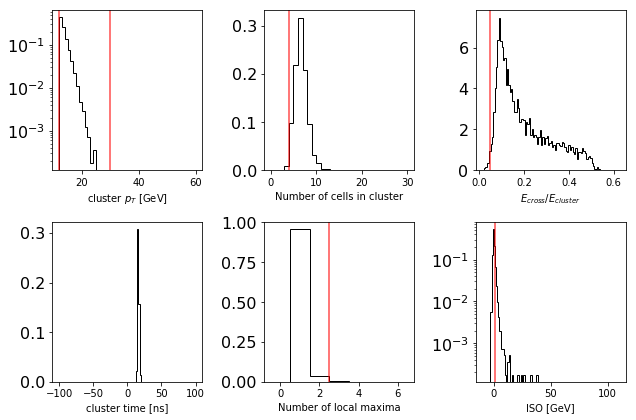

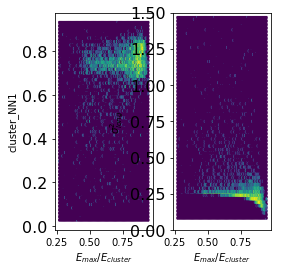

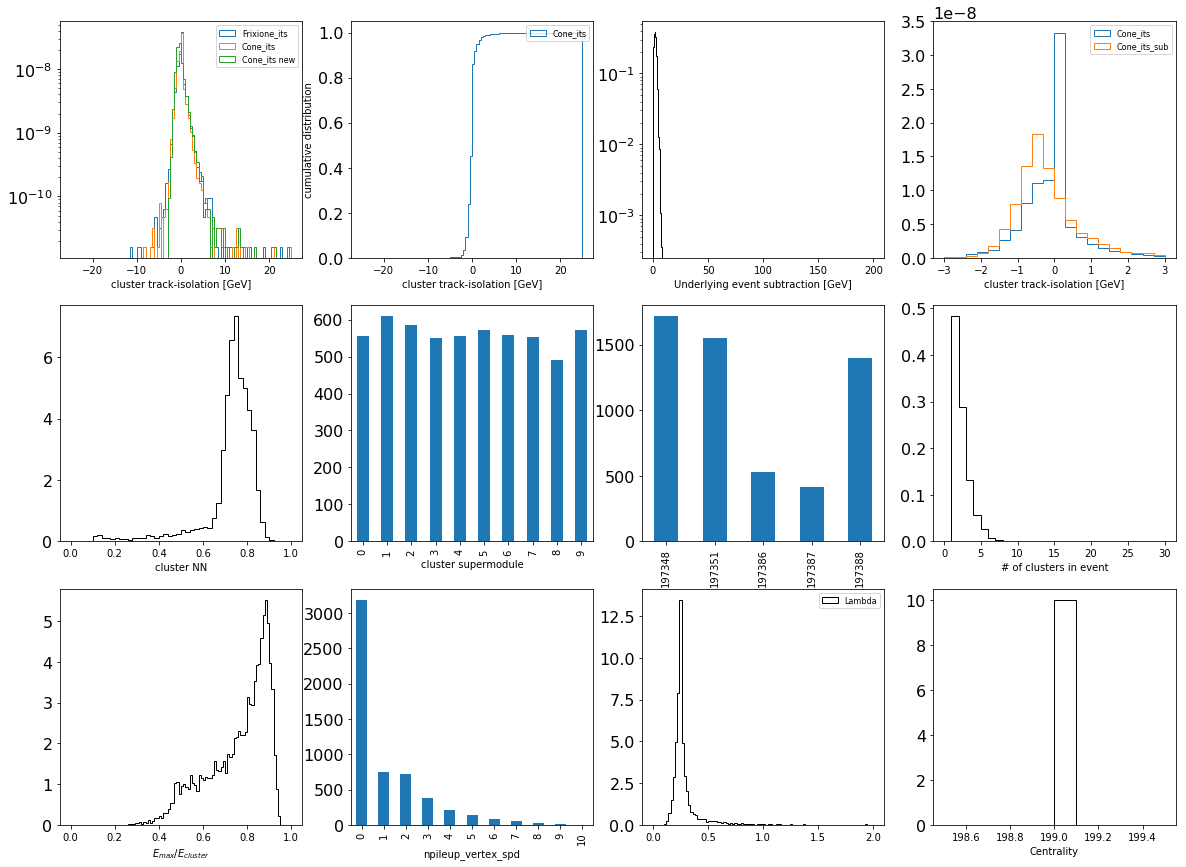

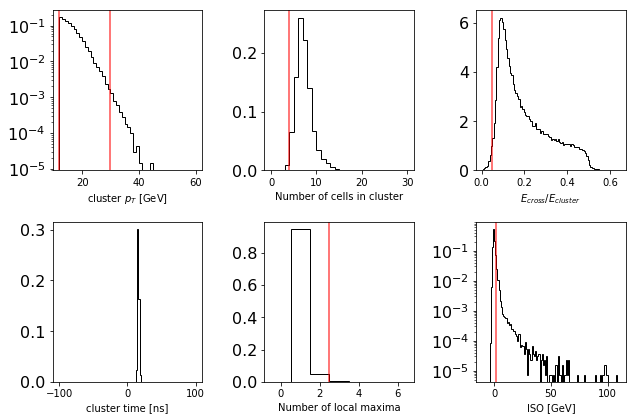

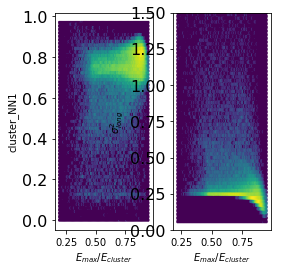

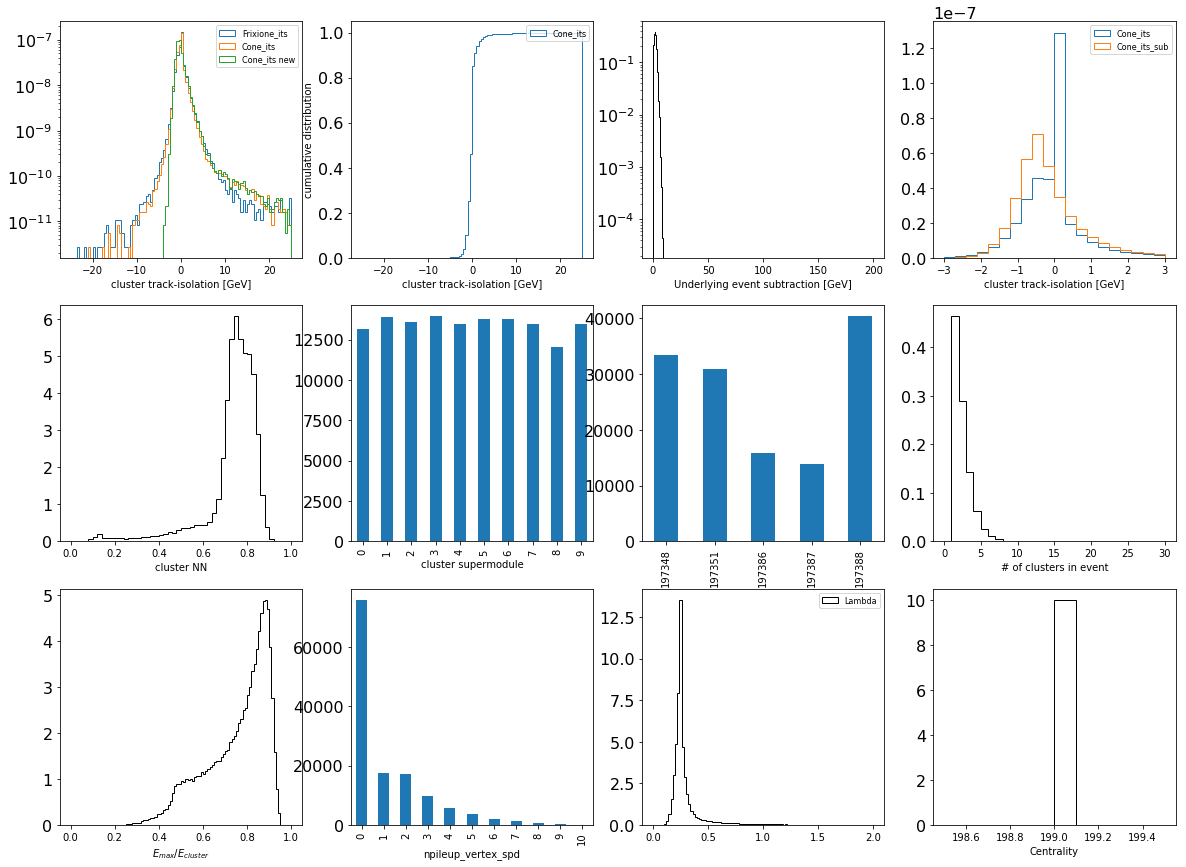

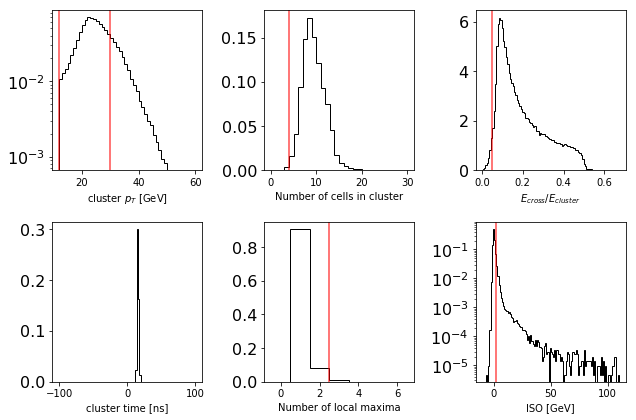

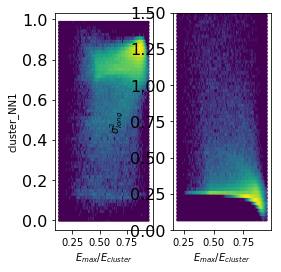

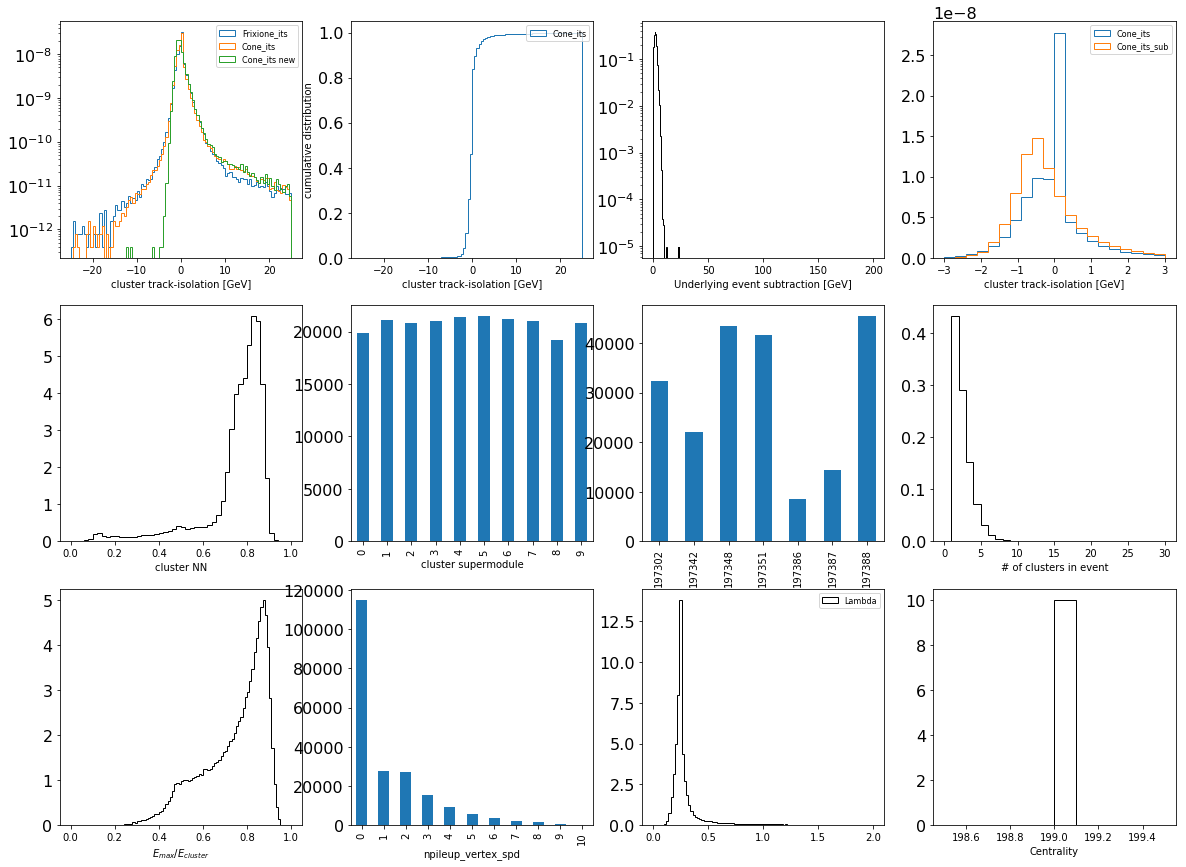

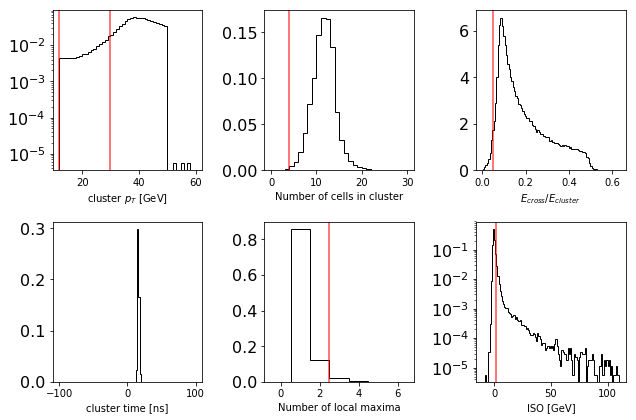

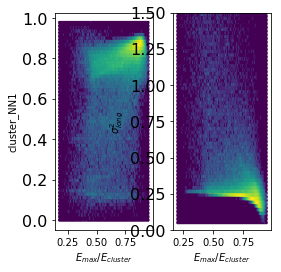

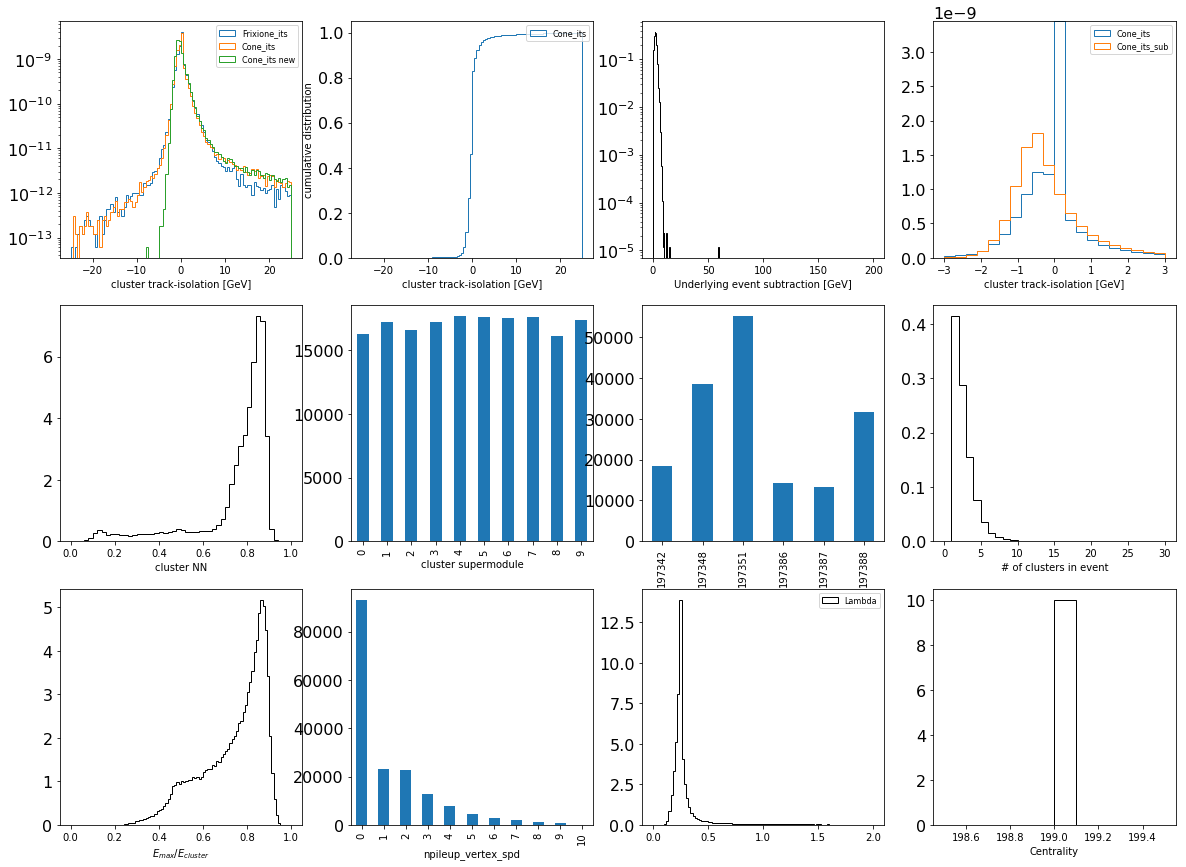

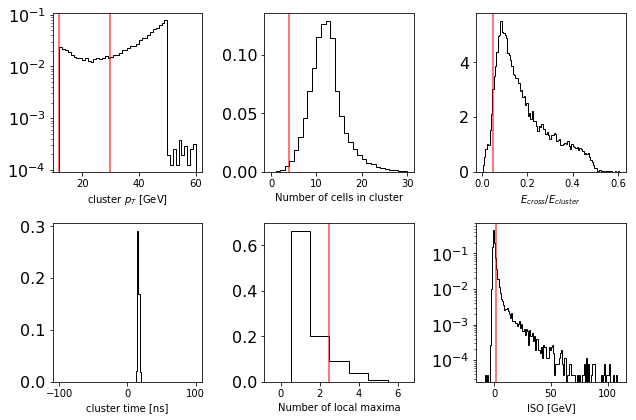

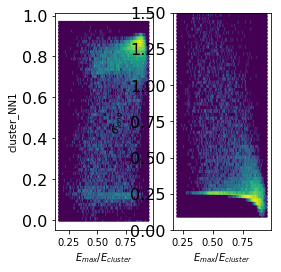

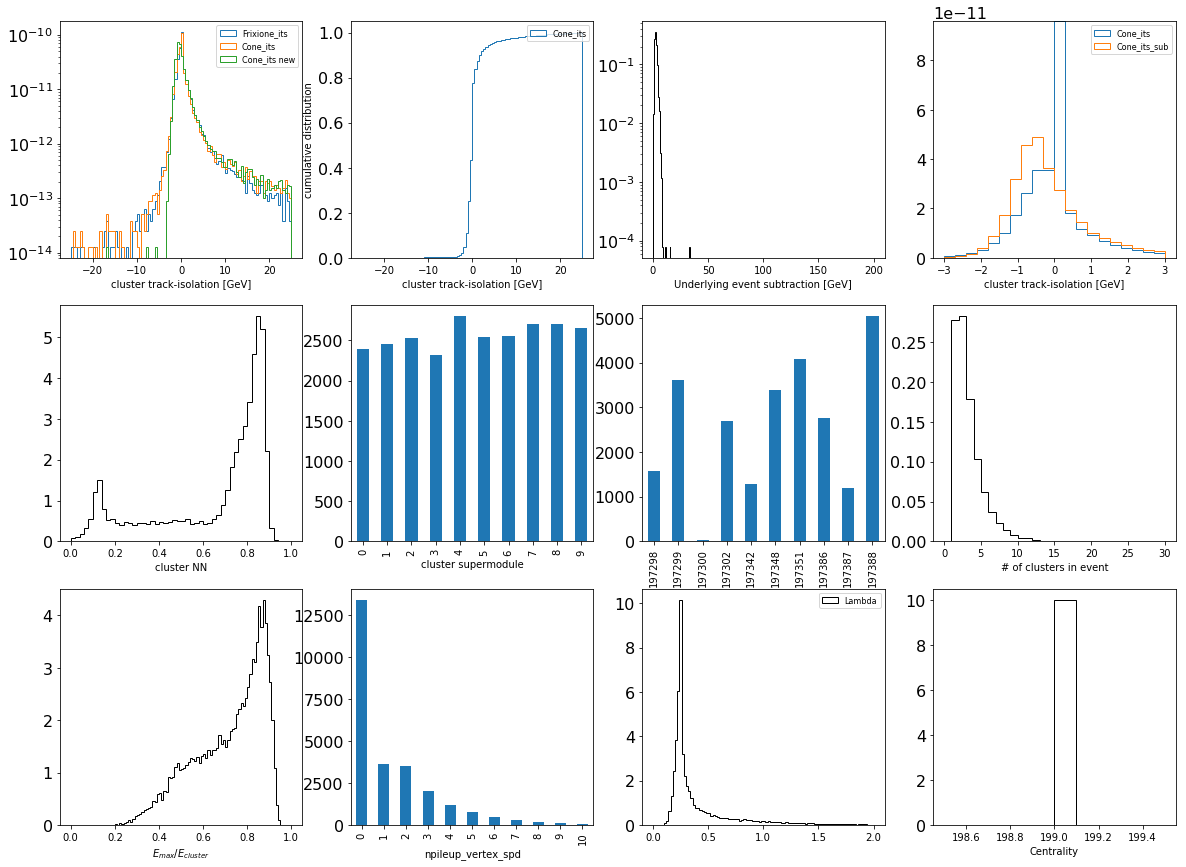

Processed Skimmed_17g6a1_pthat1_ptmin12.0_Nevent_300000.root in 3.10743498802 seconds
pt >12.0  GeV : 5685  (52.71  %)
pt <100.0  GeV : 5685  (100.00  %)
|eta| < 0.67 : 5685  (100.00  %)
ncell > 2: 5680  (99.91  %)
ecross/e > 0.05 : 5618  (98.91  %)
Local Maxima < 3 : 5602  (99.72  %)
# of isolated clusters:
cluster_iso_its_new < 1.5 GeV: 5221  (93.20  %)
cluster_iso_its_new in 4--10 GeV: 50  (0.89  %)
Processed Skimmed_17g6a1_pthat2_ptmin12.0_Nevent_300000.root in 14.2234089375 seconds
pt >12.0  GeV : 137572  (51.09  %)
pt <100.0  GeV : 137572  (100.00  %)
|eta| < 0.67 : 137529  (99.97  %)
ncell > 2: 137336  (99.86  %)
ecross/e > 0.05 : 135140  (98.40  %)
Local Maxima < 3 : 134505  (99.53  %)
# of isolated clusters:
cluster_iso_its_new < 1.5 GeV: 124235  (92.36  %)
cluster_iso_its_new in 4--10 GeV: 1372  (1.02  %)
Processed Skimmed_17g6a1_pthat3_ptmin12.0_Nevent_300000.root in 23.8202040195 seconds
pt >12.0  GeV : 215111  (48.60  %)
pt <100.0  GeV : 215111  (100.00  %)
|eta| < 0.67 : 

In [10]:
mcSignal_Files = ['Skimmed_17g6a1_pthat1_ptmin12.0_Nevent_300000.root',
                 'Skimmed_17g6a1_pthat2_ptmin12.0_Nevent_300000.root',
                 'Skimmed_17g6a1_pthat3_ptmin12.0_Nevent_300000.root',
                 'Skimmed_17g6a1_pthat4_ptmin12.0_Nevent_300000.root',
                 'Skimmed_17g6a1_pthat5_ptmin12.0_Nevent_300000.root']

#mcSignal_Files = ['Skimmed_18b10a_pthat1to6.root']
#'Skimmed_18b10a_pthat1to6.root'


#mcSignal_Files = ['Skimmed_17g6a1_pthat4_4L_allruns_ptmin15.0.root']

mcSignal_Hists = pd.concat([ applyCuts(getData([name]), name ,isMC=True)  for name in mcSignal_Files])

#mcSignal_Hists = applyCuts( getData(mcSignal_Files),mcSignal_Files[0],isMC=True)
plt.show()

## Data 

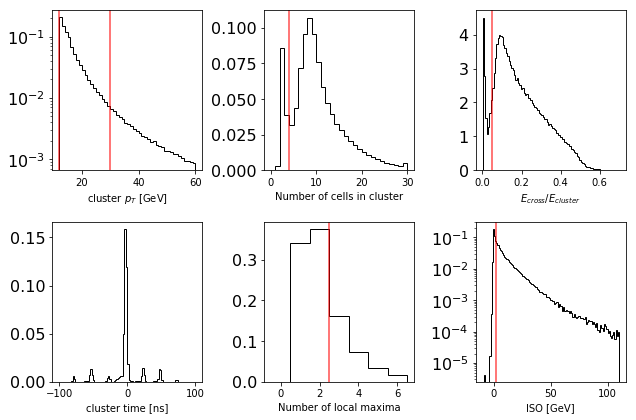

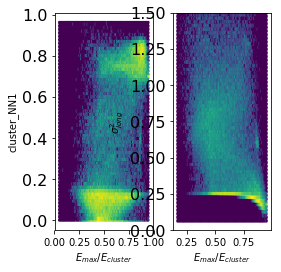

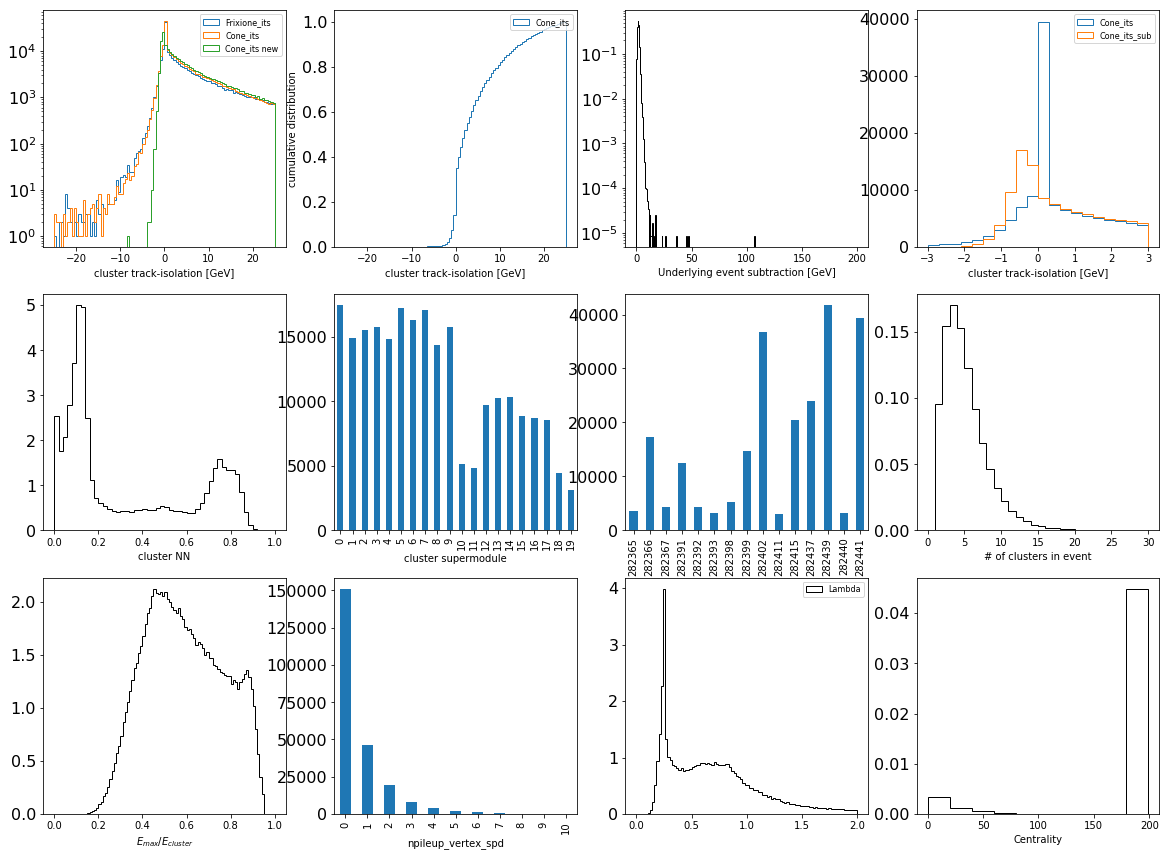

Processed Skimmed_17q.root in 42.8197219372 seconds
pt >12.0  GeV : 415247  (22.18  %)
pt <100.0  GeV : 404526  (97.42  %)
|eta| < 0.67 : 404456  (99.98  %)
ncell > 2: 369011  (91.24  %)
ecross/e > 0.05 : 330292  (89.51  %)
Local Maxima < 3 : 233297  (70.63  %)
# of isolated clusters:
cluster_iso_its_new < 1.5 GeV: 81310  (34.85  %)
cluster_iso_its_new in 4--10 GeV: 48066  (20.60  %)


In [83]:
#dataname = '5 TeV p+Pb'
#dataFiles = ['Skimmed_13def.root']
dataname = '5 TeV pp'
dataFiles = ['Skimmed_17q.root']


#dataHists = applyCuts( getData(dataFiles),dataFiles[0],isMC=False)
dataHists = pd.concat([ applyCuts(getData([name]), name ,isMC=False)  for name in dataFiles])

plt.show()


## Background MC

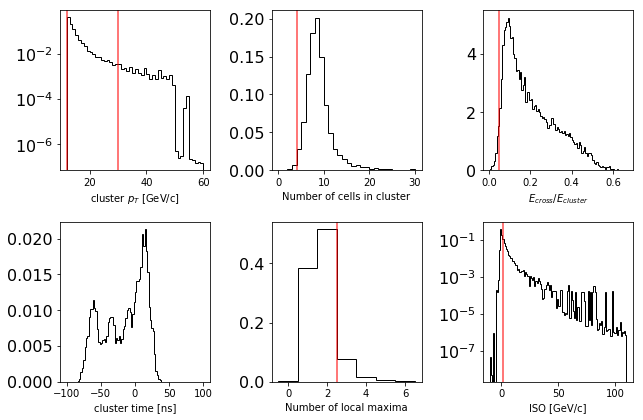

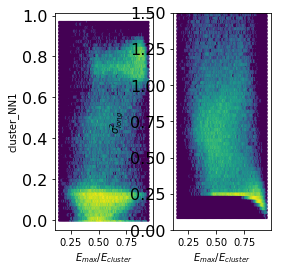

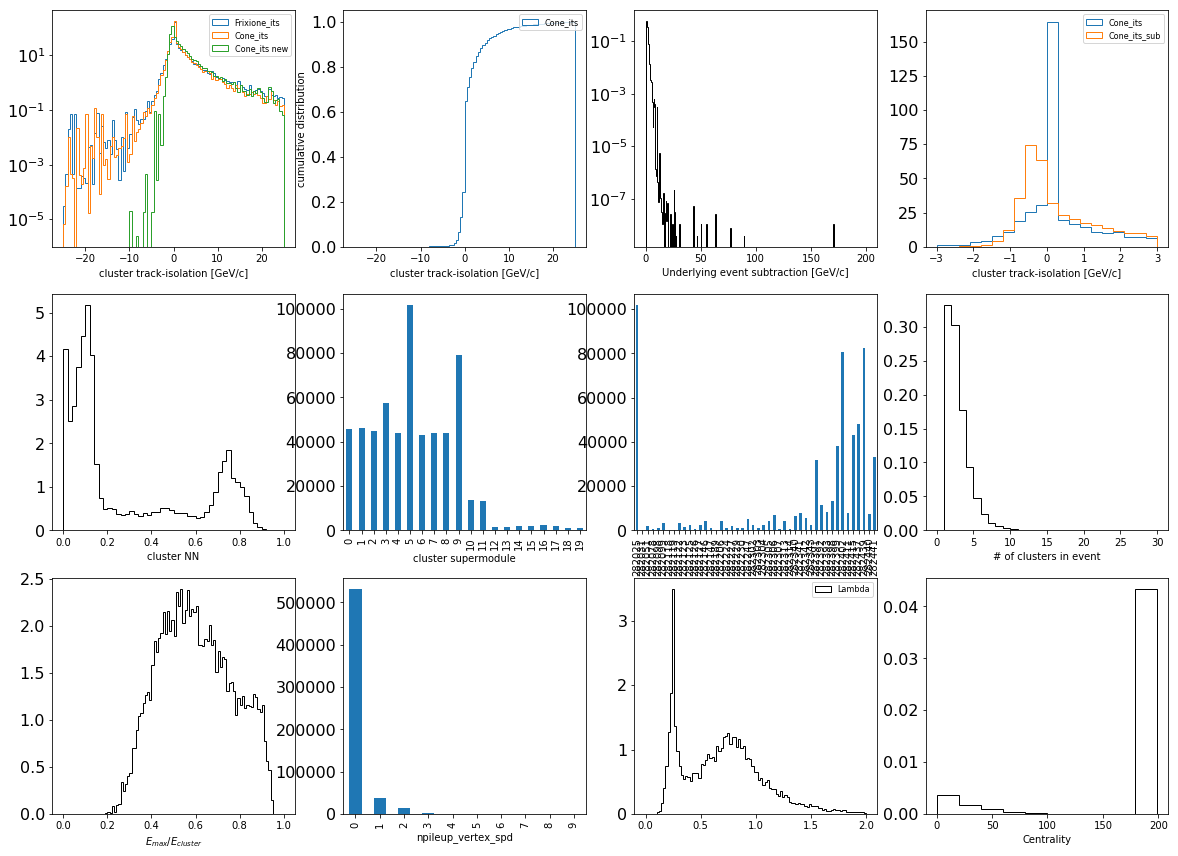

Processed 18g7a.root in 141.099269152 seconds
pt >12.0  GeV/c : 924793  (16.53  %)
pt <100.0  GeV/c : 924781  (100.00  %)
|eta| < 0.67 : 924675  (99.99  %)
ncell > 2: 924486  (99.98  %)
ecross/e > 0.05 : 889650  (96.23  %)
Local Maxima < 3 : 589803  (66.30  %)
# of isolated clusters:
cluster_iso_its_new < 1.5 GeV/c: 75781  (12.85  %)
cluster_iso_its_new in 5--10 GeV/c: 77837  (13.20  %)


In [88]:
mcBKG_Files = ['18g7a.root']

mcBKG_Hists = pd.concat([ applyCuts(getData([name]), name ,isMC=True)  for name in mcBKG_Files])

plt.show()

## PSEUDO DATA for closure studies

In [ ]:


fakeData = pd.concat([mcBKG_Hists.query('cluster_iso_its_new<1.5')[:60000], 
                      mcBKG_Hists.query('cluster_iso_its_new>1.5'),
                      mcSignal_Hists.query('cluster_iso_its_new<1.5')[:0]]) 
print fakeData.shape[0]
plt.show()

dataHists = fakeData

## NN data

In [12]:
bins_dic = {}
fitRange_dic = {}
xlabel_dic = {}
varname_dic = {}
puritymin_dic = {}
puritymax_dic = {}
limit_yaxis_dic = {}
fitRangeBKGonly_dic = {}
Range_dic = {}

In [13]:
bins_dic['NN'] = 200
fitRange_dic['NN'] = (0.00, 0.90) #0.05 --0.90
xlabel_dic['NN'] = 'Deep Neural Network Output'
varname_dic['NN'] = 'cluster_NN1'
puritymin_dic['NN'] = 0.70
puritymax_dic['NN'] = 0.90
limit_yaxis_dic['NN'] = 6.1
fitRangeBKGonly_dic['NN']=(0.0, 0.3)#(0.08, 0.23)
Range_dic['NN']=(0.0,1.0)



## Emax over Ecluster

In [14]:
bins_dic['Emax'] =220 #was 100
fitRange_dic['Emax']  = (0.04, 1.0) #0.05 --0.90
xlabel_dic['Emax']  = r'$E_{max}/E_{cluster}$'
varname_dic['Emax']  = 'cluster_emax_over_e'
puritymin_dic['Emax']  = 0.75#0.75
puritymax_dic['Emax']  = 0.95#
limit_yaxis_dic['Emax']  = 6.1
fitRangeBKGonly_dic['Emax'] =(0.0, 0.55)
Range_dic['Emax'] =(0.0,1.0)

## Lambda 

In [15]:
bins_dic['Lambda'] = 250
fitRange_dic['Lambda'] = (0.0, 1.2)
xlabel_dic['Lambda'] = r'$\sigma_{long}^{2}$'
varname_dic['Lambda'] = 'cluster_Lambda'
limit_yaxis_dic['Lambda'] = 13.0
puritymin_dic['Lambda'] = 0.0
puritymax_dic['Lambda'] = 0.3
fitRangeBKGonly_dic['Lambda']=(0.4, 1.1)#1.5
Range_dic['Lambda']=(0.0,1.2)



##ANGLE LAMBDA

In [16]:
bins_dic['LambdaAngle']  =100  #200
fitRange_dic['LambdaAngle']= (0.1, 1.2) #(0.0, 1.5)
xlabel_dic['LambdaAngle'] = r'$\sigma_{long}^{2}$ Angle'
varname_dic['LambdaAngle'] = 'cluster_Lambda_Angle'
limit_yaxis_dic['LambdaAngle'] = 13.0

puritymin_dic['LambdaAngle'] = 0.0
puritymax_dic['LambdaAngle'] = 0.3
fitRangeBKGonly_dic['LambdaAngle']=(0.4, .80)#1.5
Range_dic['LambdaAngle']=(0.0,1.2)


## Run template fit over different pt ranges

In [17]:
isomax=1.5
nonisorange=(5,10)
isolation = 'cluster_iso_its_new'


In [ ]:
 np.logspace(np.log10(12.5), np.log10(13.5), num=4)

In [ ]:
Nsig = {}
NsigError = {}

purity = {}
purityError = {}
puritySysUp = {}
puritySysDo = {}
purity_bkgonlymethod = {}
chi2perdof = {}

efficiency = {}


#binedges = [12.5       , 13.0,  14.0,  15.0, 17.5,  20.0, 25.0, 30.0 ,40,60  ] #for pPb
binedges = [12.5       , 13.0,  14.0,  15.0, 17.5,  25.0, 60  ]# for pp



bincenters = np.array([(hedge+ledge)/2.0 for ledge, hedge in zip(binedges[:-1], binedges[1:])])
binwidth = np.array([abs(hedge-ledge)/2.0 for ledge, hedge in zip(binedges[:-1], binedges[1:])])



for varkey in ['NN','LambdaAngle','Lambda','Emax']:

    bins = bins_dic[varkey]  
    fitRange = fitRange_dic[varkey]
    xlabel = xlabel_dic[varkey] 
    varname = varname_dic[varkey] 
    limit_yaxis = limit_yaxis_dic[varkey] 

    puritymin = puritymin_dic[varkey] 
    puritymax =  puritymax_dic[varkey] 
    fitRangeBKGonly=fitRangeBKGonly_dic[varkey] 
    Range=Range_dic[varkey] 

    tag = dataFiles[0].split('_small')[0]+mcSignal_Files[0].split('_small')[0]+isolation


    purity[varkey]                 = []
    purityError[varkey]            = []
    puritySysDo[varkey]            = []
    puritySysUp[varkey]            = []
    purity_bkgonlymethod[varkey]   = [] 
    chi2perdof[varkey]                     = []
    
    Nsig[varkey] = []
    NsigError[varkey] = []
    efficiency[varkey] =[]
    
    previousResult = 1000
    for ipt in range(len(binedges)-1):
        ptmin = binedges[ipt]
        ptmax = binedges[ipt+1]
        #print title
        title = r'%2.1f < $p_{T}$ < %2.1f GeV'%(ptmin, ptmax)
        print title

        maskpt_do = dataHists.cluster_pt>ptmin
        maskpt_up = dataHists.cluster_pt<ptmax
        maskdata = maskpt_do & maskpt_up 

        mcmaskpt_do = mcSignal_Hists.cluster_pt>ptmin
        mcmaskpt_up = mcSignal_Hists.cluster_pt<ptmax  
        maskmc   = mcmaskpt_do & mcmaskpt_up
    
        Templates = getTemplates(dataHists[maskdata], mcSignal_Hists[maskmc], bins,  isocut=isomax, nonisocuts=nonisorange, 
                                 var = varname,  varRange=Range, isovar=isolation)
        dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
       
    
        ##BACKGROUND ONLY FIT
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, 
                         fitRange=fitRangeBKGonly, fixN=False,fixNsig=True,Nsig0=0.0,verbosity=0)
        #tf.plotFit(xlabel, title, False, puritymin, puritymax, normalize=False,figureFilename=varname+'ptmin%2.0f_ptmax%2.0f_%s_Iso_%2.0f_Noniso%2.0f_%2.0f_BKGONLYFIT.pdf'%(ptmin,ptmax,tag,10.0*isomax, 10.0*nonisorange[0],10.0*nonisorange[1]))

        p, pmin, pmax = tf.getPurity(puritymin, puritymax)
        
        total = np.sum(tf.data[pmin:pmax])
        bkg_estimate = tf.fitN*np.sum(tf.bkg[pmin:pmax]) 
        signal_estimate = (total-(1-tf.fitNsig)*bkg_estimate)
        p = signal_estimate/total
             
        purity_bkgonlymethod[varkey].append(p)
        print 'bkg only purity' , p
        
    
    
    
        #perform normal fit, with simulation. Use bkg-only fit Nsig as starting value.
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, Nsig0= signal_estimate , fitRange=fitRange)

        #tf.plotFit(xlabel, title, True, puritymin, puritymax,
       #            normalize=False, 
        #           figureFilename=varname+'ptmin%2.0f_ptmax%2.0f_%s_Iso%2.0f_Noniso%2.0f_%2.0f.pdf'%(ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
   
        Nsig[varkey].append(tf.fitNsig)
        previousResult = tf.fitNsig
        NsigError[varkey].append(tf.fitNsigerr)
   
        #get chi2/dof
        chi2perdof[varkey].append(tf.chi2/tf.dof)

        ##get purity
        p, pmin, pmax = tf.getPurity(puritymin, puritymax)
        eff = tf.getEfficiency(puritymin,puritymax)
        efficiency[varkey].append(eff)
        puritylow = getPurity(tf.signal, tf.bkg, tf.binEdges, (tf.fitNsig-tf.fitNsigerr)/tf.fitN, puritymin, puritymax)
        purityhigh = getPurity(tf.signal, tf.bkg, tf.binEdges,  (tf.fitNsig+tf.fitNsigerr)/tf.fitN, puritymin, puritymax)
        print 'ptmin = %2.2f; ptmax =%2.2f // purity %2.2f =/- %2.2f'%(ptmin, ptmax, p,  max(abs(p-puritylow), abs(p-purityhigh) ))
        print 'efficiency=%2.2f' %(eff)
    
        
        
        
        purity[varkey].append(p)
        perror = abs(puritylow-purityhigh)/2.0
        purityError[varkey].append( perror)
        puritySysDo[varkey].append(p-np.sqrt(0.06*0.06+perror*perror))
        puritySysUp[varkey].append(p+np.sqrt(0.06*0.06+perror*perror))
        
        
        
       


In [ ]:
fig, ax = plt.subplots(1, figsize=(9,9))
myfontsize = 23
xmaximo = 60
label = {}
label['Lambda'] = r'$\sigma_{long}^{2}$'
label['LambdaAngle'] = r'$\sigma_{long}^{2}$ Angle'

label['Emax']   =  r'$E_{max}/E_{cluster}$'
label['NN']     = 'DNN'

color = {}
color['Lambda'] = 'dodgerblue'
color['Emax']   = 'green'
color['NN']     = 'orange'

for varkey in ['NN','Emax','Lambda']:
    plt.errorbar(bincenters,Nsig[varkey]/(2*binwidth), xerr = binwidth, yerr = NsigError[varkey]/(2*binwidth), 
                 label=label[varkey], linestyle="None",marker='o', alpha=0.85)

    
a = Nsig['Lambda']
b = Nsig['NN']
c = Nsig['Emax']
l = [a,b,c]
average = [sum(i)/3.0 for i in zip(*l)]


plt.errorbar(bincenters,average/(2*binwidth), label='Average', linestyle="-", linewidth=2.5, alpha=0.85, marker=None,color='black')

plt.legend(loc='best',fontsize=myfontsize,frameon=False)
plt.title(dataname ,fontsize=myfontsize)
plt.ylabel(r'dN/d$p_{T}$',fontsize=myfontsize)
plt.xlabel(r'cluster $p_{T}$ [GeV/c]',fontsize=myfontsize)
#plt.ylim(ymin=0.0)
plt.yscale('log', nonposy='clip')
plt.xlim(xmin=12,xmax=xmaximo)

plt.show()
fig.tight_layout()

fig.savefig('Spectra_%s.pdf'%dataFiles[0])


fig, ax = plt.subplots(1, figsize=(9,9))

for varkey in ['NN','Emax','Lambda']:
    
    plt.errorbar(bincenters,np.divide(Nsig[varkey],average), xerr = binwidth,  yerr=np.divide(NsigError[varkey],average),
                 label=label[varkey], linestyle="None", marker='o', alpha=0.5)

    
plt.legend(loc='best',fontsize=myfontsize,frameon=False)
plt.title(dataname ,fontsize=myfontsize)
plt.ylabel('Ratio to Average',fontsize=myfontsize)
plt.xlabel(r'cluster $p_{T}$ [GeV/c]',fontsize=myfontsize)
plt.ylim(ymin=0.0,ymax=2.0)
plt.xlim(xmin=12,xmax=xmaximo)
ax.fill_between(bincenters+binwidth,0.85,1.15,alpha=0.2, label='15% Syst uncertainty',color='black')

plt.show()
fig.tight_layout()

fig.savefig('SpectraRatio_%s.pdf'%dataFiles[0])


plt.clf()
fig, ax = plt.subplots(1, figsize=(9,9))


for varkey in ['NN','Emax','Lambda']:
    
    plt.errorbar(bincenters, chi2perdof[varkey], xerr = binwidth, label=label[varkey], marker='o')

    
plt.legend(loc='best',fontsize=myfontsize,frameon=False)
plt.title(dataname ,fontsize=myfontsize)
plt.ylabel('Chi2 per dof',fontsize=myfontsize)
plt.xlabel(r'cluster $p_{T}$ [GeV/c]',fontsize=myfontsize)
plt.ylim(ymin=0.0,ymax=3.0)
plt.xlim(xmin=12,xmax=xmaximo)
plt.ylim(ymin=0.0)
#ax.fill_between(bincenters,0.85,1.15,alpha=0.2, label='15% Syst uncertainty',color='black')

plt.show()
fig.tight_layout()

fig.savefig('Chi2_%s.pdf'%dataFiles[0])



fig, ax = plt.subplots(1, figsize=(9,9))

plt.errorbar(bincenters,purity['Lambda'], xerr = binwidth, yerr = purityError[varkey], label='Template fit', linestyle="None", alpha=0.9, marker='o')
ax.fill_between(bincenters,puritySysDo['Lambda'],puritySysUp['Lambda'],alpha=0.2)

#plt.errorbar(bincenters,purity['LambdaAngle'], xerr = binwidth, yerr = purityError[varkey], label='Template fit, angle', linestyle="None", alpha=0.9, marker='o')
#ax.fill_between(bincenters,puritySysDo['LambdaAngle'],puritySysUp['LambdaAngle'],alpha=0.2)

    #plt.errorbar(bincenters,purity[varkey], xerr = binwidth, yerr = systematic, label=varkey, linestyle="None", alpha=0.3, marker='o')

    
x = np.array([11,13,15,17,19,22.5,27.5,35.0,50])
y = np.array([0.193191, 0.277126, 0.325119, 0.381229, 0.450115, 0.491837, 0.521378, 0.546777, 0.643158])


ystat = np.array([0.0224782, 0.0316375, 0.043516,0.0189481, 0.0227371, 0.0196182, 0.0298453, 0.0347046, 0.0468214])
ysys = np.array([0.021847, 0.0282663, 0.0388568, 0.0355463, 0.0403336, 0.0444923, 0.0493448, 0.0542536, 0.0605971])

ydo = [a - b for a, b in zip(y, ysys)]
yup = [a + b for a, b in zip(y, ysys)]

xerror = [1,1,1,1,1,2.5,2.5,5,10]

plt.errorbar(x, y, xerr=xerror, yerr=ystat, marker='o',  linestyle="None", alpha=0.65, label='ABCD method')
ax.fill_between(x, ydo, yup ,alpha=0.2)


plt.ylabel('Purity', fontsize=myfontsize)
plt.xlabel(r'cluster $p_{T}$ [GeV/c]',fontsize=myfontsize)
plt.ylim(ymin=0.0,ymax=1.0)
plt.xlim(xmin=12,xmax=xmaximo)

plt.legend(loc='best',fontsize=myfontsize,frameon=False)
plt.title(dataname ,fontsize=myfontsize)
plt.show()

fig.tight_layout()
fig.savefig('purity_ABCD_%s.pdf'%dataFiles[0])


fig, ax = plt.subplots(1, figsize=(9,9))

for varkey in ['NN','Emax','Lambda']:
    plt.errorbar(bincenters,purity[varkey], xerr = binwidth, yerr = purityError[varkey], label=label[varkey], 
                 linestyle="None", alpha=0.9, marker='o')
    ax.fill_between(bincenters,puritySysDo[varkey],puritySysUp[varkey],alpha=0.2)


    
    
plt.xlim(xmin=12.0,xmax=xmaximo)
plt.ylabel('Purity', fontsize=myfontsize)
plt.xlabel(r'cluster $p_{T}$ [GeV/c]',fontsize=myfontsize)
plt.ylim(ymin=0.0,ymax=1.0)
plt.legend(loc='best',fontsize=myfontsize,frameon=False)
plt.title(dataname ,fontsize=myfontsize)
plt.xlim(xmin=12,xmax=xmaximo)

plt.show()

fig.tight_layout()
fig.savefig('purity_Comparison_%s.pdf'%dataFiles[0])


plt.clf()
fig, ax = plt.subplots(1, figsize=(9,9))
for varkey in ['NN','Emax','Lambda']:
    plt.errorbar(bincenters,efficiency[varkey], xerr = binwidth,  label=label[varkey], linestyle="None", marker='o')
plt.ylim(ymin=0.0,ymax=1.0)
plt.legend(loc='best',fontsize=myfontsize,frameon=False)
plt.title(dataname ,fontsize=myfontsize)
plt.xlim(xmin=12,xmax=xmaximo)
plt.ylabel('Shower-shape cut efficiency', fontsize=myfontsize)
plt.xlabel(r'cluster $p_{T}$ [GeV]',fontsize=myfontsize)
plt.show()
fig.tight_layout()
fig.savefig('ShowerShapeEfficiency_%s.pdf'%dataFiles[0])



plt.clf()
fig, ax = plt.subplots(1, figsize=(9,9))
plt.subplot(1,3,1)

plt.errorbar(bincenters,purity['Lambda'], xerr = binwidth, yerr = purityError[varkey], label='Template fit', linestyle="None", alpha=0.9, marker='o')
plt.errorbar(bincenters, purity_bkgonlymethod['Lambda'], xerr = binwidth, label='Template fit', alpha=0.9, linestyle="None",marker='*')
plt.ylim(ymin=0.0,ymax=1.0)


plt.subplot(1,3,2)
plt.errorbar(bincenters,purity['NN'], xerr = binwidth, yerr = purityError[varkey], label='Template fit', linestyle="None", alpha=0.9, marker='o')
plt.errorbar(bincenters, purity_bkgonlymethod['NN'], xerr = binwidth, label='Template fit', alpha=0.9,linestyle="None", marker='*')
plt.ylim(ymin=0.0,ymax=1.0)



plt.subplot(1,3,3)
plt.errorbar(bincenters,purity['Emax'], xerr = binwidth, yerr = purityError[varkey], label='Template fit', linestyle="None", alpha=0.9, marker='o')
plt.errorbar(bincenters, purity_bkgonlymethod['Emax'], xerr = binwidth, label='Template fit',linestyle="None", alpha=0.9, marker='*')


plt.ylim(ymin=0.0,ymax=1.0)

plt.show()
fig.tight_layout()

print purity['Lambda']
print purity_bkgonlymethod['Lambda']

#plt.clf()
#plt.errorbar(bincenters,np.diff(), xerr = binwidth, yerr = purityError[varkey], label='Template fit', linestyle="None", alpha=0.9, marker='o')
#plt.show()

In [ ]:

tag = dataFiles[0].split('_small')[0]+mcSignal_Files[0].split('_small')[0]+isolation
#binedges = [15.0, 16.0,17.0,18.0,20.0,22.5,25.0]#,60.0] # [16.0,17.0,18.0,19.0,20.0,22.0,24.0,25.0,30.0,40.0,60.0]
binedges = [13,14]
bincenters = np.array([(hedge+ledge)/2.0 for ledge, hedge in zip(binedges[:-1], binedges[1:])])
binwidth = np.array([abs(hedge-ledge)/2.0 for ledge, hedge in zip(binedges[:-1], binedges[1:])])

PerSuperModule = False
nsupermodules = 20
SplitEta       = False
cutbadSM      = False

varkey = 'Lambda'
bins = 80
fitRange = fitRange_dic[varkey]
xlabel = xlabel_dic[varkey] 
varname = varname_dic[varkey] 
limit_yaxis = limit_yaxis_dic[varkey] 

puritymin = puritymin_dic[varkey] 
puritymax =  puritymax_dic[varkey] 
fitRangeBKGonly=fitRangeBKGonly_dic[varkey] 
Range=Range_dic[varkey] 

for ipt in range(len(binedges)-1):
    ptmin = binedges[ipt]
    ptmax = binedges[ipt+1]
    title = r'%2.1f < $p_{T}$ < %2.1f GeV'%(ptmin, ptmax)
    maskpt_do = dataHists.cluster_pt>ptmin
    maskpt_up = dataHists.cluster_pt<ptmax
    maskdata = maskpt_do & maskpt_up 

    mcmaskpt_do = mcSignal_Hists.cluster_pt>ptmin
    mcmaskpt_up = mcSignal_Hists.cluster_pt<ptmax  
    maskmc   = mcmaskpt_do & mcmaskpt_up
    
    
    
    
    Templates = getTemplates(dataHists[maskdata], mcSignal_Hists[maskmc], bins,  isocut=isomax, nonisocuts=nonisorange, 
                             var = varname,  varRange=Range, isovar=isolation)
    dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
    tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
    tf.plotFit(xlabel, title, True, puritymin, puritymax,
               normalize=False, 
               figureFilename=varname+'ptmin%2.0f_ptmax%2.0f_%s_Iso%2.0f_Noniso%2.0f_%2.0f.pdf'%(ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
   
    ##get purity
    purity, pmin, pmax = tf.getPurity(puritymin, puritymax)
    puritylow = 0
    purityhigh = 0
    print 'ptmin = %2.2f; ptmax =%2.2f // purity %2.2f =/- %2.2f'%(ptmin, ptmax, purity,  max(abs(purity-puritylow), abs(purity-purityhigh) ))
    purityarreglo.append(purity)
    purityErrorarreglo.append( max(abs(purity-puritylow), abs(purity-purityhigh) ))
    if(cutbadSM):
        dataveto = dataHists.cluster_SuperModule!=3
        dataveto2 = dataHists.cluster_SuperModule!=7
        mcveto =  mcSignal_Hists.cluster_SuperModule!=3
        mcveto2 =  mcSignal_Hists.cluster_SuperModule!=7

        Templates = getTemplates(dataHists[maskdata & dataveto & dataveto2],
                                 mcSignal_Hists[maskmc & mcveto & mcveto2], 
                                 bins,  isocut=isomax, nonisocuts=nonisorange, var = varname,  varRange=Range, isovar=isolation)
        dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
        tf.plotFit(xlabel, title, True, puritymin, puritymax,
                   normalize=False, figureFilename=varname+'NoSM3or7_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.pdf'%(ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
    
    
    maskseta_data = [dataHists.cluster_eta>0, dataHists.cluster_eta<0]
    maskseta_mc   = [mcSignal_Hists.cluster_eta>0, mcSignal_Hists.cluster_eta<0]
   
    if SplitEta:
        for ieta in range(2):
            Templates = getTemplates(dataHists[maskdata & maskseta_data[ieta]], mcSignal_Hists[maskmc & maskseta_mc[ieta]], bins, 
                                     isocut=isomax, nonisocuts=nonisorange, var = varname,  varRange=Range, isovar=isolation)
            dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
            tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
            tf.plotFit(xlabel, title, True, puritymin, puritymax,normalize=False,
                       figureFilename=varname+'Eta_%d_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.pdf'%(ieta,ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
    
    
    if(PerSuperModule):
        purityarray = []
        purityerrarray = []

        purityarrayVeto = []
        
        farray = []
        farrayVeto = []
        fErrarray = []
        fErrarrayVeto = []
        
        chi2 = []
        chi2Veto = [] 
        bins = 200
        fig = plt.figure(figsize=(24,24))
        for ism in range(nsupermodules ):
            masksm = dataHists.cluster_SuperModule==ism
            plt.subplot(2,nsupermodules/2 ,ism+1)
            plt.hist2d(dataHists[maskdata & masksm].cluster_eta, dataHists[maskdata &masksm].cluster_phi,range=([-.70, .70], 
                       [-np.pi, np.pi]),bins=100)
        plt.show()
        #fig.tight_layout()
        fig.savefig('supermodules.png')
        for ism in range(nsupermodules):
            mask_supermodules_data = dataHists.cluster_SuperModule==ism
            mask_supermodules_mc   = mcSignal_Hists.cluster_SuperModule==ism
            maskdata_sm = maskdata & mask_supermodules_data
            maskmc_sm  = maskmc & mask_supermodules_mc
        
            bins = 120 #was 80
            Templates = getTemplates(dataHists[maskdata_sm], mcSignal_Hists[maskmc_sm], bins,  isocut=isomax, nonisocuts=nonisorange, 
                                     var = varname,  varRange=Range, isovar=isolation)
            dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
            tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges,
                             verbosity=0, fitRange=fitRange)

            tf.plotFit(xlabel, title, True, puritymin, puritymax, normalize=False,
                       figureFilename=varname+'SuperModule%d_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.pdf'%(ism,ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
        
            #Everything EXCEPT the SM = ism
            purity, pmin, pmax = tf.getPurity(puritymin, puritymax)
            puritylow = 0
            purityhigh = 0
            
            purityarray.append(purity)
            purityerrarray.append(max(abs(purity-puritylow), abs(purity-purityhigh) ))
            farray.append(tf.fitNsig)
            fErrarray.append(tf.fitNsigerr)
            chi2.append(tf.chi2/tf.dof)
            
            bins = 120
            mask_supermodules_data = dataHists.cluster_SuperModule!=ism
            mask_supermodules_mc   = mcSignal_Hists.cluster_SuperModule!=ism
            maskdata_sm = maskdata & mask_supermodules_data
            maskmc_sm  = maskmc & mask_supermodules_mc
            
            Templates = getTemplates(dataHists[maskdata_sm], mcSignal_Hists[maskmc_sm], bins,  isocut=isomax, nonisocuts=nonisorange,
                                     var = varname,  varRange=Range, isovar=isolation)
            dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
            tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, 
                              verbosity=0, fitRange=fitRange)
            tf.plotFit(xlabel, title, True, puritymin, puritymax, normalize=False,
                       figureFilename=varname+'VetoSuperModule%d_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.pdf'%(ism,ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
            purity, pmin, pmax = tf.getPurity(puritymin, puritymax)

            purityarrayVeto.append(purity)
            
            farrayVeto.append(tf.fitNsig)
            fErrarrayVeto.append(tf.fitNsigerr)
            chi2Veto.append(tf.chi2/tf.dof)
            
            
           


     
            
        fig = plt.figure(figsize=(12,3))
        plt.subplot(121)
        
        plt.plot(range(nsupermodules),purityarrayVeto, marker='o')
        plt.ylim([0.0,1.0])
        
        if 'NN' in varname:
            ylabel = 'Purity with DNN fit'
        else:
            ylabel = 'Purity with Lambda fit'
            
        plt.ylabel(ylabel)
        plt.xlabel('Removed Supermodule #')
        plt.axhline(y=np.average(purityarrayVeto),color='r',label='Average =%2.1f%%'%(100.0*np.average(purityarrayVeto)))
        plt.legend(title=dataname, loc='best')
        
        plt.subplot(122)
        plt.errorbar(range(nsupermodules),purityarray, yerr=purityerrarray, linestyle="None", marker='o')
        plt.ylim([0.0,1.0])
        plt.ylabel(ylabel)
        plt.xlabel('Supermodule #')
        plt.axhline(y=np.average(purityarray),color='r',label='Average =%2.1f%%'%(100.0*np.average(purityarray)))
        plt.axhspan(np.average(purityarray)-np.std(purityarray), 
                    np.average(purityarray)+np.std(purityarray),
                    color='r',
                    label='+/- RMS =%2.1f'%(100.0*np.std(purityarray)), alpha=0.4)
        plt.legend(title=dataname, loc='best')

        print 'PURITY RMS = ' , np.std(purityarray)
        
        fig.tight_layout()
        plt.show()
        fig.savefig('SuperModules_SummaryPurity'+varname+tag+'.pdf')
        plt.clf()
        
        plt.subplot(121)
        plt.plot(range(nsupermodules),chi2Veto, marker='o')
        plt.ylim([0.0,3.0])
        plt.ylabel('Chi2/dof')
        plt.xlabel('Removed Supermodule #')
        plt.axhline(y=np.average(chi2Veto),color='r',label='Average')

        plt.subplot(122)
        plt.plot(range(nsupermodules),chi2, marker='o')
        plt.ylim([0.0,3.0])
        plt.ylabel('Chi2/dof')
        plt.xlabel('Supermodule #')
        plt.axhline(y=np.average(chi2),color='r',label='Average')
        
        
        plt.show()
        fig.savefig('SuperModules_SummaryPurity'+varname+tag+'.pdf')
   


              
        fig = plt.figure(figsize=(12,5))
        plt.subplot(121)
        
        plt.errorbar(range(nsupermodules),farrayVeto, yerr=fErrarrayVeto,marker='o')
        plt.ylim([0.0,1.0])
        plt.ylabel('Fraction')
        plt.xlabel('Removed Supermodule #')
        plt.axhline(y=np.average(farrayVeto),color='r',label='Average')
       # plt.show()
        #fig.savefig('supermodulesVetoFraction.png')   

        plt.subplot(122)
        #fig = plt.figure(figsize=(12,12))
        plt.errorbar(range(nsupermodules),farray, yerr=fErrarray,marker='o')
        plt.ylim([0.0,1.0])
        plt.ylabel('Fraction')
        plt.xlabel('Supermodule #')
        plt.axhline(y=np.average(farray),color='r',label='Average')
        plt.show()
        fig.savefig('SummaryFraction'+varname+tag+'.png')
        
        plt.show()
        
print purityarreglo
print purityErrorarreglo



x = [11,13,15,17,19,22.5,27.5,35.0,50]
y = [0.193191, 0.277126, 0.325119, 0.381229, 0.450115, 0.491837, 0.521378, 0.546777, 0.643158]
yerror = [0.0224782, 0.0316375,0.043516, 0.0189481, 0.0227371, 0.0196182, 0.0298453, 0.0347046, 0.0468214]
xerror = [1,1,1,1,1,2.5,2.5,5,10]
fig = plt.figure(figsize=(6,6))
plt.errorbar(bincenters,purityarreglo, xerr=binwidth, yerr=purityErrorarreglo, alpha=0.5, color='black', linestyle="None", marker='o', label='Template Fit')
plt.errorbar(x, y, xerr=xerror, yerr=yerror, marker='o',  linestyle="None", alpha=0.4, label='ABCD method')
plt.ylim([0.0,1.00])
plt.xlim([10.0, 62.0])
plt.ylabel('Purity')
plt.xlabel(r'$p_{T}$ [GeV]')
plt.legend()
plt.show()
fig.savefig('Purity_'+varname+tag+'.pdf')


In [ ]:
plt.plot(bincenters, [0.33324522, 0.29435754, 0.2948806, 0.43981975, 0.52505141, 0.55698127, 0.52820379, 0.52450752])
plt.plot(bincenters, [0.44355085, 0.44128826, 0.47394377, 0.5392772, 0.5766626, 0.62544429, 0.59503043, 0.60428977])
plt.plot(bincenters, [0.39109263, 0.34360024, 0.31159431, 0.47637609, 0.48879293, 0.53994912, 0.48959836, 0.5494228])
#plt.plot([11,13,15,17,19,22.5,27.5,35.0,50], [0.193191, 0.277126, 0.325119, 0.381229, 0.450115, 0.491837, 0.521378, 0.546777, 0.643158])
plt.show()

# PLOT TEMPLATES

In [ ]:
tf.plotTemplates(xlabel,'Templates_'+varname+'_'+tag+'.pdf')

plt.show()

# Run on test data, including bkg only fit to bkg dominated region

In [ ]:
#bins = 50 #75

#nonisoranges=[(3.0,10.0), (2.0,10.0), (4.0,10.0), (3,15.0), (2.0,15.0), (4.0,15.0)]
nonisoranges = [(4.0,10.0)]
for nonisorange in nonisoranges:
    #binedges = [10.0, 11.0,13.0,16.0]
    binedges = [20.0,30.0]
    for ipt in range(len(binedges)-1):
        ptmin = binedges[ipt]
        ptmax = binedges[ipt+1]
    
        maskpt_do = dataHists.cluster_pt>ptmin
        maskpt_up = dataHists.cluster_pt<ptmax
        maskdata = maskpt_do & maskpt_up 

        mcmaskpt_do = mcSignal_Hists.cluster_pt>ptmin
        mcmaskpt_up = mcSignal_Hists.cluster_pt<ptmax  
        maskmc   = mcmaskpt_do & mcmaskpt_up
    
        title = r'%2.1f < $p_{\mathrm{T}}$ < %2.1f GeV'%(ptmin, ptmax)
        Templates = getTemplates(dataHists[maskdata], mcSignal_Hists[maskmc], bins,  isocut=isomax, nonisocuts=nonisorange,
                             var = varname, varRange=Range, isovar=isolation)
        dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
    #fit normally in the entire fit range
        #fitRange=(0.0, 1.0)
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
        tf.plotFit(xlabel, title, True, puritymin, puritymax, normalize=False,figureFilename=varname+'ptmin%2.0f_ptmax%2.0f_%s_Iso_%2.0f_Noniso%2.0f_%2.0f.pdf'%(ptmin,ptmax,tag,10.0*isomax, 10.0*nonisorange[0],10.0*nonisorange[1]))
        #fit with N float and f=0 fixed in bkg dominated region
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRangeBKGonly, fixN=False,fixNsig=True,Nsig0=0.0)
        tf.plotFit(xlabel, title, False, puritymin, puritymax, normalize=False,figureFilename=varname+'ptmin%2.0f_ptmax%2.0f_%s_Iso_%2.0f_Noniso%2.0f_%2.0f_BKGONLYFIT.pdf'%(ptmin,ptmax,tag,10.0*isomax, 10.0*nonisorange[0],10.0*nonisorange[1]))

    #tf.plotResiduals(varname,'residualBKGOnly.png')




# COMPARISON between DATA and MC

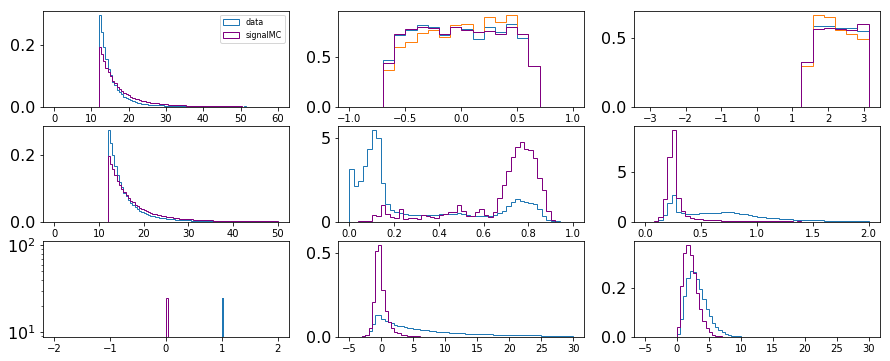

In [34]:
fig = plt.figure(figsize=(15,6))
plt.subplot(3,3,1)

#nonisorange = 'cluster_iso_its_04_sub>5.0 and cluster_iso_its_04_sub<10.0'
nonisorange = 'cluster_iso_its_new>5.0 and cluster_iso_its_new<10.0 '
isorange    = 'cluster_iso_its_new<1.5'

plt.hist(dataHists.query(isorange)['cluster_pt'],range=(0,60), bins=100,histtype='step', normed=True, label='data')
plt.hist(mcSignal_Hists.query(isorange)['cluster_pt'],range=(0,60), bins=100,histtype='step',color ='purple', normed=True,
         weights=mcSignal_Hists.query(isorange)['weights'],label='signalMC')
#plt.hist(mcSignal_Hists['cluster_pt'],range=(10,16), bins=10,histtype='step', normed=True)

plt.legend()
netabins = 20
plt.subplot(3,3,2)
plt.hist(dataHists['cluster_eta'],range=(-1.0,1.0), bins=netabins,histtype='step', normed=True)
plt.hist(dataHists.query('cluster_iso_its_04<1.0')['cluster_eta'],range=(-1.0,1.0), bins=netabins,histtype='step', normed=True)
plt.hist(mcSignal_Hists['cluster_eta'],range=(-1.0,1.0), bins=netabins,color ='purple', histtype='step', normed=True, weights=mcSignal_Hists['weights'])

nphibins = 20
plt.subplot(3,3,3)
plt.hist(dataHists['cluster_phi'],range=(-np.pi,np.pi), bins=nphibins,histtype='step', normed=True)
plt.hist(dataHists.query('cluster_iso_its_04<1.0')['cluster_phi'],range=(-np.pi,np.pi), bins=nphibins,histtype='step', normed=True)
plt.hist(mcSignal_Hists['cluster_phi'],range=(-np.pi,np.pi), bins=nphibins,color ='purple', histtype='step', normed=True, weights=mcSignal_Hists['weights'])

plt.subplot(3,3,4)

plt.hist(dataHists['cluster_pt'],range=(0,50), bins=100,histtype='step', normed=True)
plt.hist(mcSignal_Hists['cluster_pt'],range=(0,50), bins=100,histtype='step',color ='purple', normed=True,
         weights=mcSignal_Hists['weights'])

plt.subplot(3,3,5)
plt.hist(dataHists.query(nonisorange)['cluster_NN1'],range=(0,1.0), 
         bins=50,histtype='step', normed=True)
plt.hist(mcSignal_Hists.query(nonisorange)['cluster_NN1'],range=(0,1.0), 
         bins=50,histtype='step',color ='purple', normed=True,weights=mcSignal_Hists.query(nonisorange)['weights'])



plt.subplot(3,3,6)
plt.hist(dataHists['cluster_Lambda'],range=(0,2.0), bins=50,histtype='step', normed=True)
plt.hist(mcSignal_Hists['cluster_Lambda'],range=(0,2.0), bins=50,histtype='step',color ='purple', normed=True,weights=mcSignal_Hists['weights'])


plt.subplot(3,3,7)
plt.hist(dataHists['weights'],range=(-2,2), bins=100, normed=True)
plt.hist(mcSignal_Hists['weights'],range=(-2,2), bins=100,histtype='step',color ='purple', 
         normed=True, weights=mcSignal_Hists['weights'])

plt.yscale('log', nonposy='clip')



plt.subplot(3,3,8)
plt.hist(dataHists['cluster_iso_its_04_sub'],range=(-5,30.0), bins=70,histtype='step', normed=True)
plt.hist(mcSignal_Hists['cluster_iso_its_04_sub'],range=(-5,30.0), bins=70,histtype='step',color ='purple', 
         normed=True, weights=mcSignal_Hists['weights'])



plt.subplot(3,3,9)
plt.hist(dataHists['ue_estimate_its_const'],range=(-5,30.0), bins=70,histtype='step', normed=True)
plt.hist(mcSignal_Hists['ue_estimate_its_const'],range=(-5,30.0), bins=70,histtype='step',color ='purple', 
         normed=True, weights=mcSignal_Hists['weights'])

plt.show()


plt.clf()

## SHOWER SHAPES FOR SIGNAL

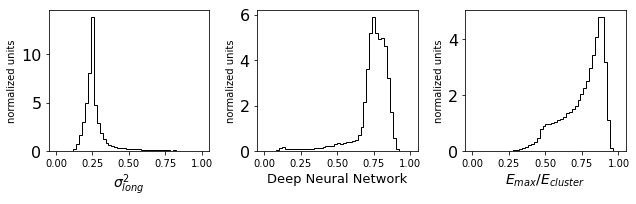

In [35]:
fig = plt.figure(figsize=(9,3))
plt.subplot(1,3,2)
plt.hist(mcSignal_Hists['cluster_NN1'], bins=50,range=(0,1.0), color='black',histtype='step', normed=True,
        weights=mcSignal_Hists['weights'])
plt.xlabel('Deep Neural Network', fontsize=13)
plt.ylabel('normalized units')

    
plt.subplot(1,3,3)
plt.hist(mcSignal_Hists['cluster_emax_over_e'], bins=50,range=(0,1.0), normed=True,
             color='black', histtype='step',weights=mcSignal_Hists['weights'])
plt.xlabel(r'$E_{max}/E_{cluster}$',fontsize=14)
plt.ylabel('normalized units')

plt.subplot(1,3,1)
plt.hist(mcSignal_Hists['cluster_Lambda'], bins=50,range=(0,1.0), normed=True,
             color='black', histtype='step',weights=mcSignal_Hists['weights'])
plt.xlabel(r'$\sigma_{long}^{2}$', fontsize=14)
plt.ylabel('normalized units')

fig.tight_layout()
fig.savefig('ShowerShapeVariables_IsoClusters_%s.pdf'%name)
plt.show()

## SIGNAL MC ISOLATION DISTRIBUTION and UE

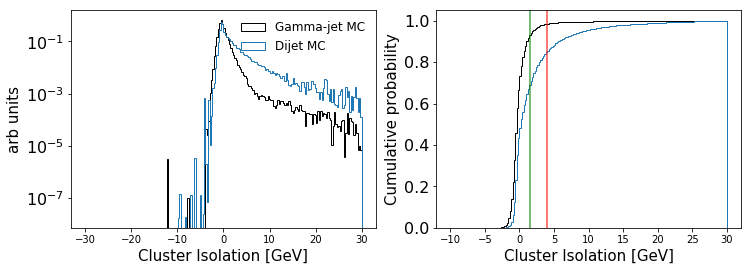

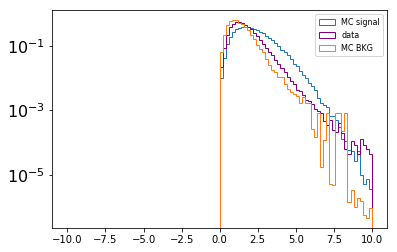

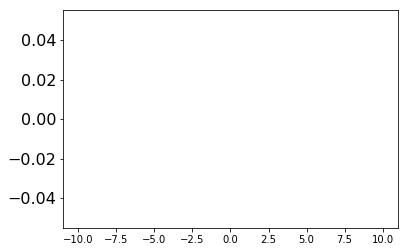

2.29153
1.12964653969


In [89]:

fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

#nonisorange = 'cluster_iso_its_04_sub>5.0 and cluster_iso_its_04_sub<10.0'
nonisorange = 'cluster_iso_its_04_sub>5.0 and cluster_iso_its_04_sub<10.0 and cluster_pt<30'
isorange    = 'cluster_iso_its_04_sub<1.5.0 and cluster_iso_truth<3.0 and cluster_pt<30'

plt.hist(mcSignal_Hists.query('cluster_pt<20')['cluster_iso_its_04_sub'],normed=True, label='Gamma-jet MC', range=(-30,30.0), bins=200,histtype='step', color='black',
          weights=mcSignal_Hists.query('cluster_pt<20')['weights'])
plt.hist(mcBKG_Hists['cluster_iso_its_04_sub'],normed=True, label='Dijet MC', range=(-30,30.0), bins=200,histtype='step',
          weights=mcBKG_Hists['weights'])

plt.legend(loc='best',fontsize=12,frameon=False)

plt.xlabel('Cluster Isolation [GeV]',fontsize=15)
plt.ylabel('arb units',fontsize=15)

#plt.axvline(x=1.0,color='g',alpha=0.7)

#plt.axvline(x=3.0,color='r',alpha=0.7)

#plt.hist(mcSignal_Hists['cluster_iso_its_04'],range=(-10,10.0), bins=60,histtype='step', 
#         weights=mcSignal_Hists['weights'])



#plt.hist(mcSignal_Hists['cluster_frixione_its_04_02'],range=(-10,10.0), bins=60,histtype='step', 
#         weights=mcSignal_Hists['weights'])

plt.yscale('log', nonposy='clip')


plt.subplot(1,2,2)

plt.hist(mcSignal_Hists['cluster_iso_its_04_sub'],cumulative=True, color='black', normed=True, range=(-10,30.0), bins=200,histtype='step', 
          weights=mcSignal_Hists['weights'], label='Gamma-jet MC')
plt.hist(mcBKG_Hists['cluster_iso_its_04_sub'],cumulative=True, normed=True, range=(-10,30.0), bins=200,histtype='step', 
          weights=mcBKG_Hists['weights'], label='Dijet MC')

plt.xlabel('Cluster Isolation [GeV]',fontsize=15)
plt.ylabel('Cumulative probability',fontsize=15)
#plt.legend(loc='best',fontsize=12,frameon=False)

plt.axvline(x=1.5,color='g',alpha=0.7)

plt.axvline(x=4.0,color='r',alpha=0.7)

plt.show()
fig.tight_layout()

fig.savefig('IsolationMCsignal_%s.pdf'%mcSignal_Files[0].split('_small')[0])

plt.clf()


plt.hist(mcSignal_Hists['ue_estimate_its_const'],range=(-10,10.0), label='MC signal', bins=100,histtype='step', 
         normed=True, weights=mcSignal_Hists['weights'])

plt.hist(dataHists['ue_estimate_its_const'],range=(-10,10.0), bins=100, label = 'data' , histtype='step',color ='purple', 
         normed=True)

plt.hist(mcBKG_Hists['ue_estimate_its_const'],range=(-10,10.0), bins=100, label = 'MC BKG' , histtype='step',
         normed=True, weights=mcBKG_Hists['weights'])

plt.yscale('log', nonposy='clip')

plt.legend()

print np.average(mcSignal_Hists.query('ue_estimate_its_const<100')['ue_estimate_its_const'])
print np.std(mcSignal_Hists.query('ue_estimate_its_const<100')['ue_estimate_its_const'])


plt.show()

plt.clf()

plt.hist(mcSignal_Hists['cluster_isHardPhoton'],range=(-10,10.0), bins=30,histtype='step',color ='purple', 
         normed=True, weights=mcSignal_Hists['weights'])
plt.show()


# Isolation fraction

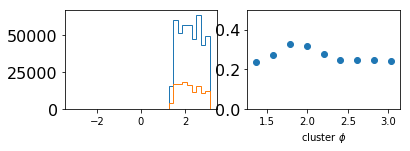

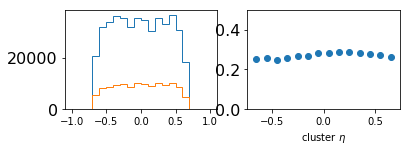

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide


In [23]:
fig = plt.figure()
test = dataHists
#test = test.query('cluster_pt<16 and cluster_pt>10')
testiso = test.query('cluster_iso_its_04_sub<1.0')

plt.subplot(2,2,1) 

A, x, _ = plt.hist(test['cluster_phi'], range=(-np.pi, np.pi), bins=30, histtype='step')
B, x, _ = plt.hist(testiso['cluster_phi'], range=(-np.pi, np.pi), bins=30, histtype='step')

plt.subplot(2,2,2) 

AB = np.divide(B,A)

x= np.delete(x,-1)
x = np.add( x, (x[1]-x[0])/2.0 )
plt.scatter(x, AB)
plt.xlabel(r'cluster $\phi$')
plt.ylim(ymin=0.0,ymax=0.50)
plt.show()

plt.subplot(2,2,3) 


A, x, _ = plt.hist(test['cluster_eta'], range=(-1.0, 1.0), bins=20, histtype='step')
B, x, _ = plt.hist(testiso['cluster_eta'], range=(-1.0, 1.0), bins=20, histtype='step')

plt.subplot(2,2,4) 

AB = np.divide(B,A)

x= np.delete(x,-1)
x = np.add( x, (x[1]-x[0])/2.0 )
plt.scatter(x, AB)
plt.xlabel(r'cluster $\eta$')
plt.ylim(ymin=0.0,ymax=0.50)
plt.show()

fig.tight_layout()
fig.savefig('IsolationFraction_%s.pdf'%dataFiles[0].split('_small')[0])

##Checking isolation distribution and probabilities

In [ ]:
    #plt.hist(dataframe['cluster_phi'], bins=50,color='black',histtype='step', normed=True)
    #plt.xlabel(r'cluster $\phi$')

# Isolation Sideband and signal region plots

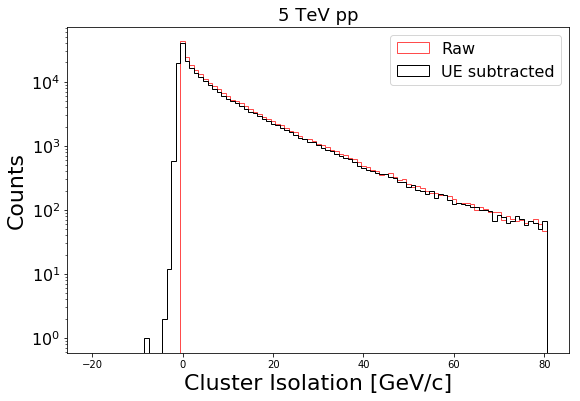

In [85]:
isotype = 'its'
isolationvar = 'cluster_iso_%s_04' %(isotype)

test = dataHists

#test = test.query('cluster_pt<16 and cluster_pt>10')
maxIso = 80.5
minIso = -20.5
nbins  = 101

mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure(figsize=(9,6))
#plt.subplot(1,2,1)
plt.hist(test['%s_raw'%isolationvar],range=(minIso,maxIso),color='red',bins=nbins,alpha=0.7,label='Raw',histtype='step')
plt.hist(test['%s_sub'%isolationvar],range=(minIso,maxIso),bins=nbins,color='black',label='UE subtracted',histtype='step')
#plt.hist(test['%s'%isolationvar],range=(minIso,maxIso),bins=nbins,color='red',label='UE subtracted (voronoi)',histtype='step')
plt.xlabel('Cluster Isolation [GeV/c]',fontsize=22)
plt.yscale('log', nonposy='clip')
plt.ylabel('Counts',fontsize=22)
plt.legend(fontsize=16)
plt.title(dataname, fontsize=18)


#plt.subplot(1,2,2)
#plt.hist(test['%s_ue'%isolationvar],range=(0.0,10),bins=nbins,alpha=0.5, label='rho x area voronoi')
#plt.hist(test['ue_estimate_its_const']*0.4*0.4*3.14,range=(0.0,10),bins=nbins,alpha=0.5, label='rho x area')
#plt.text(5, 50000, 'UE Average = %2.1f [GeV]'%(np.average(test['%s_ue'%isolationvar])), fontsize=12)
#plt.legend()
#plt.text(5, 40000, 'UE Average = %2.1f [GeV]'%(np.average(test['ue_estimate_its_const*0.4*0.4*3.14'])), fontsize=12)

plt.show()
fig.tight_layout()

fig.savefig('IsolationWithUESubtraction_%s.pdf'%dataFiles[0].split('_small')[0])


# Isolation Sideband and signal region plots

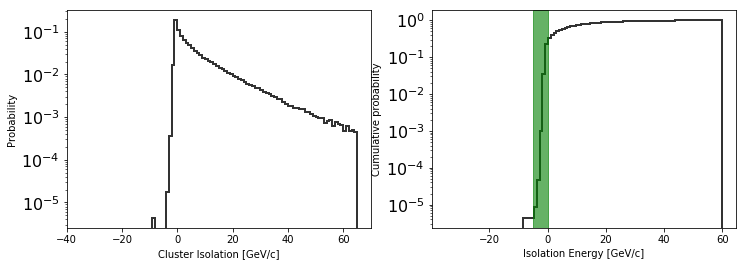

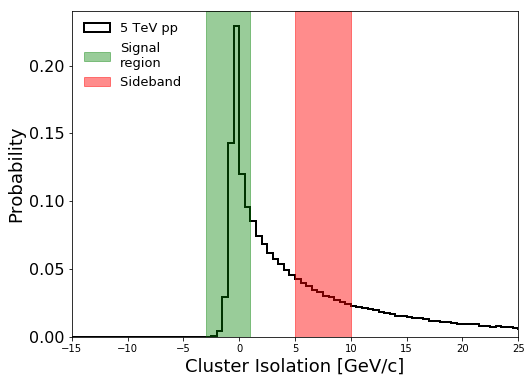

In [86]:
# Build templates from dataframes
isolationvar = 'cluster_iso_its_04_sub'
#isolationvar = 'cluster_frixione_its_04_02'
#test = dataHists.query('%s<200'%isolationvar)
test = dataHists

#test = test.query('cluster_pt<16 and cluster_pt>10')

mpl.rcParams['legend.fontsize'] = 15

fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(test[isolationvar],bins=100,range=(-35, 65),label='Data',normed=True,alpha=0.8,histtype='step',linewidth=2,color='black')
plt.xlabel('Cluster Isolation [GeV/c]')
plt.ylabel('Probability')
plt.yscale('log', nonposy='clip')
plt.subplot(1,2,2)
plt.hist(test[isolationvar],bins=100,range=(-35, 60),label='ola', cumulative=True, normed=True,alpha=0.8,histtype='step',linewidth=2,color='black')
plt.xlabel('Isolation Energy [GeV/c]')
plt.ylabel('Cumulative probability')
plt.yscale('log', nonposy='clip')
plt.axvspan(-5,0.0, color='green', alpha=0.6,label='Signal region')

plt.show()
#fig.tight_layout()
mpl.rcParams['legend.fontsize'] = 13

#fig.savefig('IsolationSideband.png')

#fig = plt.figure(figsize=(10,5))



#mpl.rcParams.update({'xtick.labelsize': 16}) 

fig = plt.figure(figsize=(8,6))
plt.hist(test[isolationvar],bins=200, range=(-35.5, 64.5), label=dataname,normed=True,histtype='step',linewidth=2,color='black')
plt.xlabel('Cluster Isolation [GeV/c]',fontsize=18)
plt.axvspan(-3,1.0, color='green', alpha=0.4,label='Signal\nregion')
plt.axvspan(5,10, color='red', alpha=0.450,label='Sideband ')
#plt.axvspan(2,15, color='orange', alpha=0.3,label='Extended\nsideband',hatch="/")
plt.legend(loc='upper left',frameon=False)
plt.ylabel('Probability',fontsize=18)
#plt.hist(test[isolationvar],bins=181, range=(-35.5, 65.5), label='Data',normed=True,histtype='step',linewidth=2,color='black')

#plt.yscale('log', nonposy='clip')

plt.xlim([-15.0,+25.0])

plt.show()
fig.tight_layout()
fig.savefig('IsolationSideband_limited_%s.pdf'%dataFiles[0].split('_small')[0])


# Sideband variations

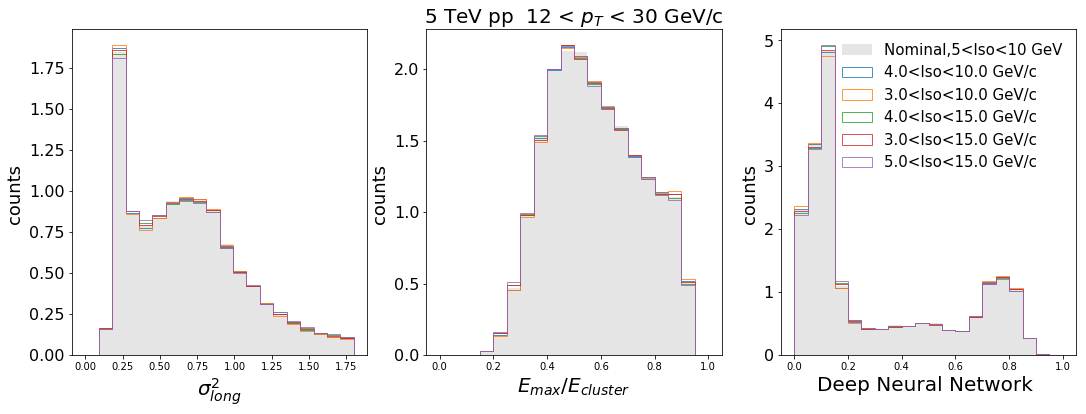

 Correlation coefficients: 
          Iso and pt 0.01
         Iso and NN1 -0.00
      Iso and Lambda 0.01
    Iso and Ecross/E 0.00
       Iso and Ncell 0.02


In [87]:
#test[test.cluster_frixione_its_04_02<2].hist(column='cluster_NN1',bins=40,label='ola',normed=True)
mpl.rcParams.update({'legend.fontsize': 8})
fig = plt.figure(figsize=(18,6))


isolationvar = 'cluster_iso_its_04_sub'

test = dataHists.query('cluster_pt<30 and cluster_pt>12')


limits =  [ (4.0,10.0), (3.0,10.0), (4.0,15.0), (3.0,15.0), (5,15)]
nrows = 2
ncolumns = 3
nbins = 20



mask = '%2.1f<%s<%2.1f '%(5,isolationvar, 10.0)



plt.subplot(1,3,2)
plt.hist(test.query(mask)['cluster_emax_over_e'], range=(0,1.0), linewidth=3.0, color='black', bins=nbins,label='Nominal,5<Iso<10 GeV',
         normed=True,alpha=0.1)#,linestyle='--')
plt.xlabel(r'$E_{max}/E_{cluster}$', fontsize=16)
plt.ylabel('counts ', fontsize=16)



plt.subplot(1,3,3)
plt.hist(test.query(mask)['cluster_NN1'], range=(0,1.0), linewidth=3.0, color='black', bins=nbins,label='Nominal,5<Iso<10 GeV',
         normed=True,alpha=0.1)#,linestyle='--')
plt.xlabel('Deep Neural Network ', fontsize=16)
plt.ylabel('counts ', fontsize=16)


plt.subplot(1,3,1)
plt.hist(test.query(mask)['cluster_Lambda'], linewidth=3.0, color='black', range=(0,1.8), bins=nbins,label='Nominal, 5<Iso<10 GeV',
         normed=True,alpha=0.1)#,linestyle='--')
plt.xlabel(r'$\sigma_{long}^{2}$', fontsize=16)
plt.ylabel('counts ', fontsize=16)

for lim in limits:
    plt.subplot(1,3,2)
    plt.title(dataname+r'  12 < $p_{T}$ < 30 GeV/c',fontsize=20)
   # plt.xlabel(r'cluster $p_{T}$ [GeV/c]')

    mask = '%2.1f<%s<%2.1f '%(lim[0],isolationvar, lim[1])

    #tag = '%2.1f<Iso<%2.1f GeV'%(lim[0],lim[1])


    tag = '%2.1f<Iso<%2.1f GeV/c'%(lim[0],lim[1])
    plt.hist(test.query(mask)['cluster_emax_over_e'], range=(0,1.0), linewidth=1.0,bins=nbins,label=tag,normed=True,alpha=0.8,histtype='step')
    plt.xlabel(r'$E_{max}/E_{cluster}$', fontsize=20)
    plt.ylabel('counts ', fontsize=18)

    plt.subplot(1,3,1)
    plt.hist(test.query(mask)['cluster_Lambda'],linewidth=1.0, range=(0,1.8), bins=nbins,label=tag,normed=True,alpha=0.8,histtype='step')
    plt.xlabel(r'$\sigma_{long}^{2}$', fontsize=20)
    plt.ylabel('counts ', fontsize=18)
    
    plt.subplot(1,3,3)

    plt.hist(test.query(mask)['cluster_NN1'], range=(0,1.0), linewidth=1.0,bins=nbins,label=tag,normed=True,alpha=0.8,histtype='step')
    plt.xlabel('Deep Neural Network ', fontsize=20)
    plt.ylabel('counts ', fontsize=18)


plt.legend( fontsize=15,frameon=False)


plt.show()
fig.tight_layout()
fig.savefig('IsolationCorrelation%s.pdf'%dataFiles[0].split('_small')[0])

test = test.query('%s>1'%isolationvar)

print ' Correlation coefficients: '
print '%20s %2.2f'%('Iso and pt',test[isolationvar].corr(test['cluster_pt']))
print '%20s %2.2f'%('Iso and NN1',test[isolationvar].corr(test['cluster_NN1']))
print '%20s %2.2f'%('Iso and Lambda',test[isolationvar].corr(test['cluster_Lambda']))


print '%20s %2.2f'%('Iso and Ecross/E',test[isolationvar].corr(test['cluster_ecross_over_e']))
print '%20s %2.2f'%('Iso and Ncell',test[isolationvar].corr(test['cluster_ncell']))




In [ ]:
print 'Correlation between Iso and pt %2.2f'%test['cluster_frixione_its_04_02'].corr(test['cluster_pt'])
print 'Correlation between Iso and NN1 %2.2f'%test['cluster_frixione_its_04_02'].corr(test['cluster_NN1'])
print 'Correlation between Iso and Lambda %2.2f'%test['cluster_frixione_its_04_02'].corr(test['cluster_Lambda'])


print 'Correlation between Iso and ncell %2.2f'%test['cluster_frixione_its_04_02'].corr(test['cluster_ncell'])



In [ ]:
calculateFitUncertainty(dataiso, signalmc, datanoniso, binEdges, puritymin, puritymax, fitRange)

In [ ]:
# vary data with poisson distribution in each bin
_ = getFitResults(varyWithinBins(dataiso, 10000), [signalmc], [datanoniso], binEdges,
                         pmin=puritymin, pmax=puritymax, verbosity=0, showDistributions=True)

In [ ]:
plotFitUncertaintyExamples(dataiso, dataisoerr, signalmc, datanoniso, binEdges)

In [ ]:
closureResults = checkClosureOverParameters(dataiso, signalmc, datanoniso, binEdges, 1000)

In [ ]:
plotCheckClosureResults(*closureResults)

# Check effect of binning

In [ ]:
def checkBinEffects(dataHists, mcHists, var, puritymin, puritymax, title,isocut, nonisocuts,isovar, fitRange=None, 
                    varRange=(0.0, 1.0)):
    dataisos, dataisoerrs = [], []
    signalmcs, signalmcerrs = [], []
    datanonisos, datanonisoerrs = [], []
    binEdgess = []        
    bins, fracs, fracerrs, purs = [], [], [], []
    reduced_chi2= []
    
    for nBins in range(20, 201,4):
        #dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = getTemplates(dataHists, mcHists, nBins,
        #var=var)
        
        #tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, 
        #                 datanonisoerr, binEdges, verbosity=0, fitRange=fitRange)
        
        Templates = getTemplates(dataHists, mcHists, nBins,  isocut=isomax, nonisocuts=nonisorange, 
                                 var = var,  varRange=varRange, isovar=isolation)
        dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, verbosity=0, fitRange=fitRange)
        bins.append(nBins)
        fracs.append(tf.fitNsig)
        fracerrs.append(tf.fitNsigerr)
        purs.append(tf.getPurity(puritymin, puritymax)[0])
        reduced_chi2.append(tf.chi2/tf.dof)
        if (nBins%10 == 0 and nBins <= 100):
            dataisos.append(dataiso)
            dataisoerrs.append(dataisoerr)
            signalmcs.append(signalmc)
            signalmcerrs.append(signalmcerr)
            datanonisos.append(datanoniso)
            datanonisoerrs.append(datanonisoerr)
            binEdgess.append(binEdges)
            


    fig = plt.figure()
    #plt.errorbar(bins, fracs, fracerrs, fmt='ko', label='Fit signal fraction')
    plt.plot(bins, fracs,  'o', label='Fit signal fraction')

    plt.plot(bins, purs, 'bd', label='Purity')
    plt.xlabel('Number of bins',fontsize=15)
    plt.ylim([0.0, 0.5])
    plt.legend(loc='best', fontsize=15, numpoints=1)
    plt.title(title,fontsize=15)
    fig.tight_layout()
    fig.savefig('Binning_purity_%s.pdf'%title) 

    ax = plt.gca()
    #ax.axhspan(np.mean(purs)-0.02, np.mean(purs)+0.02, color='green', alpha=0.2)
    
    plt.show()
    
    fig = plt.figure()
    plt.plot(bins, reduced_chi2,'-o')
    plt.ylabel(r'$\chi^{2}$/dof', fontsize=15)
    plt.xlabel('Number of bins',fontsize=15)
    plt.ylim(ymin=0.0)
    plt.title(title,fontsize=15)
    plt.legend(loc='best', fontsize=15, numpoints=1)
    plt.show()
    fig.tight_layout()
    fig.savefig('Binning_chi2_%s.pdf'%title) 

    
    
    

In [28]:
isomax=1.0
nonisorange=(3,10)
isolationvar = 'cluster_iso_its_04_sub'


checkBinEffects(dataHists, mcSignal_Hists, 'cluster_NN1', 0.5, 0.85, 'DNN',  varRange=(0,1.0), isocut=isomax, 
                nonisocuts=nonisorange, isovar=isolationvar, fitRange= (0.05, 0.88))

checkBinEffects(dataHists, mcSignal_Hists, 'cluster_Lambda', 0.0, 0.40, 'Lambda',  varRange=(0,2.0), isocut=isomax, 
                nonisocuts=nonisorange, isovar=isolationvar, fitRange=(0.0, 1.5))

NameError: name 'checkBinEffects' is not defined

In [ ]:
checkBinEffects(dataHists, mcHists, 'cluster_Lambda', 0.0, 0.40, '$\lambda$', None, varRange=(0.0, 1.0))

In [ ]:
import random

random.sample(range(10), 10)

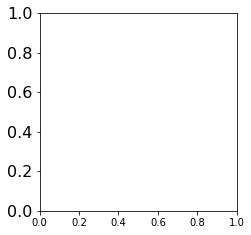

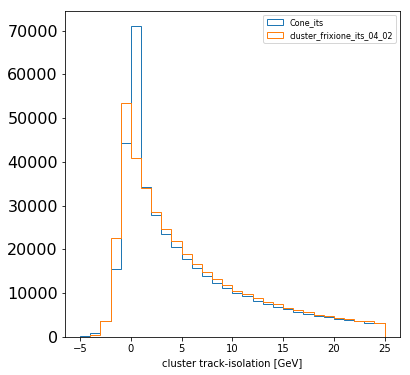

In [29]:
fig = plt.figure(figsize=(6,6))
plt.hist(dataHists['cluster_iso_its_04'], range=(-5,25), bins=30,label='Cone_its',histtype='step')
plt.hist(dataHists['cluster_iso_its_04_sub'], range=(-5,25), bins=30,label='cluster_frixione_its_04_02',histtype='step')
#plt.axvline(x=2.0, color='r')
#plt.axvline(x=5.0, color='g')
#plt.yscale('log', nonposy='clip')
plt.legend(loc='best')
plt.xlabel('cluster track-isolation [GeV]')
plt.show()

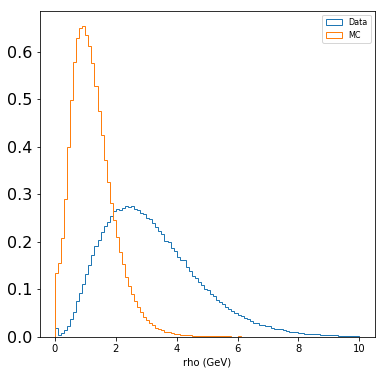

In [30]:
fig = plt.figure(figsize=(6,6))
plt.hist(dataHists['ue_estimate_its_const'], range=(0,10), bins=100,label='Data',histtype='step',density=True)
plt.hist(mcBKG_Hists["ue_estimate_its_const"], range=(0,10), bins=100, label='MC', histtype='step',density=True)

plt.legend(loc='best')
plt.xlabel('rho (GeV)')
plt.show()


## COMPARE ISO AND NON-ISO REGIONS IN MC

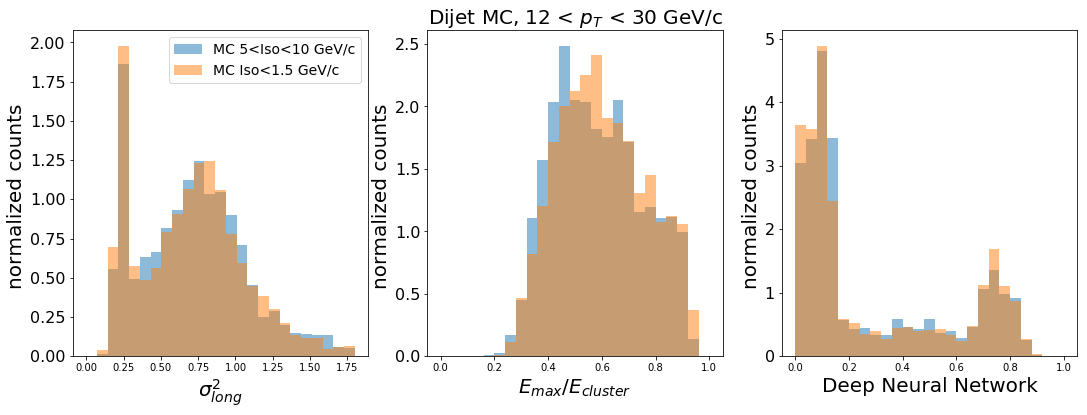

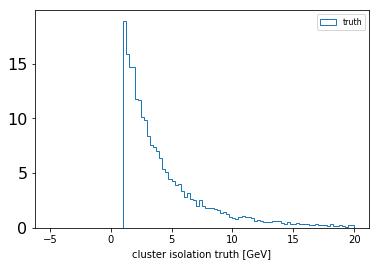

In [115]:
nbins = 25
fig = plt.figure(figsize=(18,6))#fig = plt.figure()

plt.subplot(1,3,3)

MCtest = mcBKG_Hists.query('cluster_pt<20 and cluster_pt>12 and cluster_iso_04_truth>1')

nonisorange = 'cluster_iso_its_04_sub>5.0 and cluster_iso_its_04_sub<10.0 '
isorange    = 'cluster_iso_its_04_sub<1.5 '

plt.hist(MCtest.query(nonisorange)['cluster_NN1'],range=(0,1.0), 
         bins=nbins, density=True, label='5<Iso<10 GeV/c',alpha=0.5,  weights=MCtest.query(nonisorange)['weights'])
plt.hist(MCtest.query(isorange)['cluster_NN1'],range=(0,1.0), 
         bins=nbins, density=True,label= 'Iso<1.5 GeV/c',alpha=0.5, weights=MCtest.query(isorange)['weights'])
#plt.legend(loc='best', fontsize=14)

plt.xlabel('Deep Neural Network', fontsize=20)
plt.ylabel('normalized counts ', fontsize=20)


plt.subplot(1,3,1)

plt.hist(mcBKG_Hists.query(nonisorange)['cluster_Lambda'],range=(0,1.8), 
         bins=nbins, density=True, label='MC 5<Iso<10 GeV/c',alpha=0.5, weights=MCtest.query(nonisorange)['weights'])

plt.hist(mcBKG_Hists.query(isorange)['cluster_Lambda'],range=(0,1.8), 
         bins=nbins, density=True,label= 'MC Iso<1.5 GeV/c',alpha=0.5,weights=MCtest.query(isorange)['weights'])
plt.legend(loc='best', fontsize=14)

plt.xlabel(r'$\sigma_{long}^{2}$', fontsize=20)
plt.ylabel('normalized counts ', fontsize=20)



plt.subplot(1,3,2)

plt.hist(mcBKG_Hists.query(nonisorange)['cluster_emax_over_e'],range=(0,1.0), 
         bins=nbins, density=True, label='MC 5<Iso<10 GeV/c',alpha=0.5, weights=MCtest.query(nonisorange)['weights'])

plt.hist(mcBKG_Hists.query(isorange)['cluster_emax_over_e'],range=(0,1.0), 
         bins=nbins, density=True,label= 'MC Iso<1.5 GeV/c',alpha=0.5,weights=MCtest.query(isorange)['weights'])
#plt.legend(loc='best', fontsize=14)

plt.xlabel(r'$E_{max}/E_{cluster}$', fontsize=20)
plt.ylabel('normalized counts ', fontsize=20)

plt.title('Dijet MC,'+r' 12 < $p_{T}$ < 30 GeV/c',fontsize=20)


   # plt.hist(test.query(mask)['cluster_emax_over_e'], range=(0,1.0), linewidth=1.0,bins=nbins,label=tag,normed=True,alpha=0.8,histtype='step')
 #   plt.xlabel(r'$E_{max}/E_{cluster}$', fontsize=20)
  #  plt.ylabel('counts ', fontsize=18)

plt.show()


fig.tight_layout()
fig.savefig('ShowerShape_DijetStudy%s.pdf'%mcBKG_Files[0].split('.root')[0])



plt.hist(mcBKG_Hists['cluster_iso_04_truth'], range=(-5,20),  weights=mcBKG_Hists['weights'],bins=100,label='truth',histtype='step')

plt.legend(loc='best')
plt.xlabel('cluster isolation truth [GeV]')
plt.show()





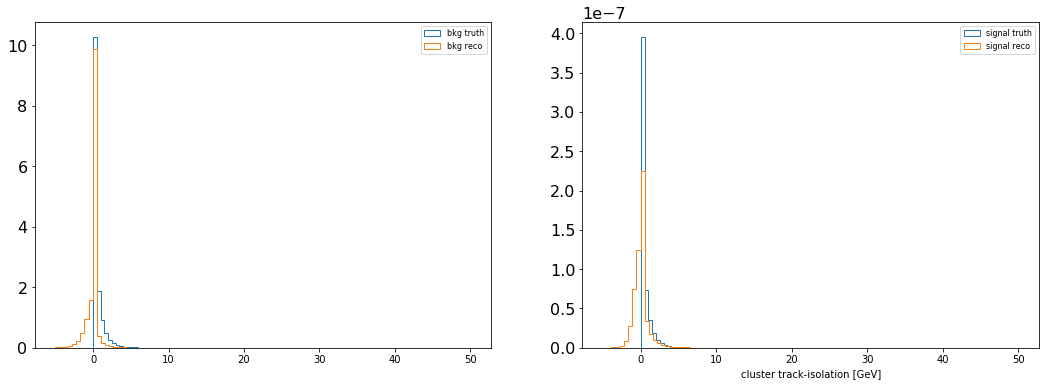

In [32]:
nbinsDNN = 100
fig = plt.figure(figsize=(18,6 ))

plt.subplot(1,2,1)

plt.hist(mcBKG_Hists['cluster_iso_04_truth'], range=(0,50),  weights=mcBKG_Hists['weights'],bins=100,label='bkg truth',histtype='step')
plt.hist(mcBKG_Hists['cluster_iso_its_04'], range=(-5,50), weights=mcBKG_Hists['weights'], bins=100,label='bkg reco',histtype='step')

plt.legend(loc='best')

plt.subplot(1,2,2)
plt.hist(mcSignal_Hists['cluster_iso_04_truth'], range=(0,50),  weights=mcSignal_Hists['weights'],bins=100,label='signal truth',histtype='step')
plt.hist(mcSignal_Hists['cluster_iso_its_04'], range=(-5,50), weights=mcSignal_Hists['weights'], bins=100,label='signal reco',histtype='step')


plt.legend(loc='best')
plt.xlabel('cluster track-isolation [GeV]')
plt.show()